# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [ ]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
#moved after note about restarting and running cells sequentially-- running this right after installation
#line resulted in error
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.19.0


In [ ]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                 # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.layers import Activation, LeakyReLU                                        # these were missing
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                                        # Importing confusion_matrix to plot the confusion matrix
from tensorflow.keras import backend                                                              # for clearing backend

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

#added this so there's gpu determinism and reproducible results
tf.config.experimental.enable_op_determinism()

# **Data Overview**


##Loading the data

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the image file of the dataset
rgb_images = np.load('/content/drive/My Drive/AI Cert Course/Computer Vision/Project 6/images_proj.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/My Drive/AI Cert Course/Computer Vision/Project 6/Labels_proj.csv')

In [ ]:
#check the shape of the rgb images set
rgb_images.shape

(631, 200, 200, 3)

There are 631 images, of size 200 x 200, with 3 channels (as expected since they're rgb images).

In [ ]:
#check the shape of the labels csv
labels.shape

(631, 1)

There are 631 rows and one column in the labels file.

In [ ]:
#check the number of labels
labels.nunique()

Label    2
dtype: int64

There are 2 label categories.

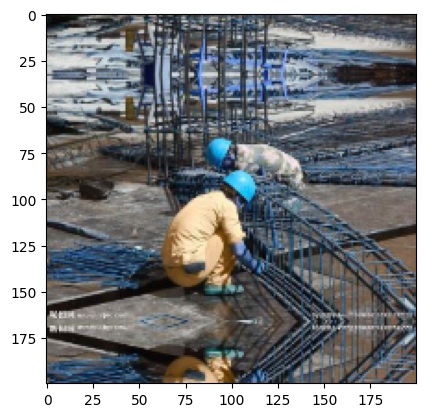

In [ ]:
#inspect one of the images
plt.imshow(rgb_images[63]);

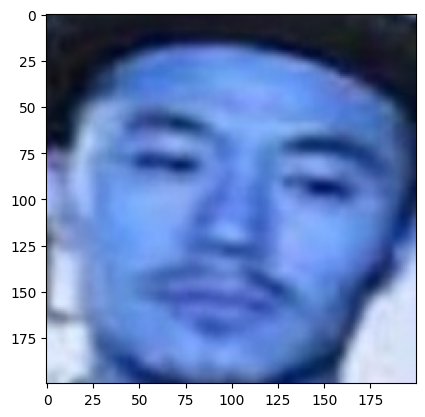

In [ ]:
#inspect one of the images
plt.imshow(rgb_images[482]);

# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

In [ ]:
#function from computer vision extra case study -- randomly selects images and displays
#in 3x4 grid, and shows corresponding labels
def plot_images(images,labels):
    keys=dict(labels['Label'])
    rows = 3
    cols = 4
    fig = plt.figure(figsize=(10, 8))
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(labels))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.imshow(images[random_index, :])
            ax.set_title(keys[random_index])
    plt.show()

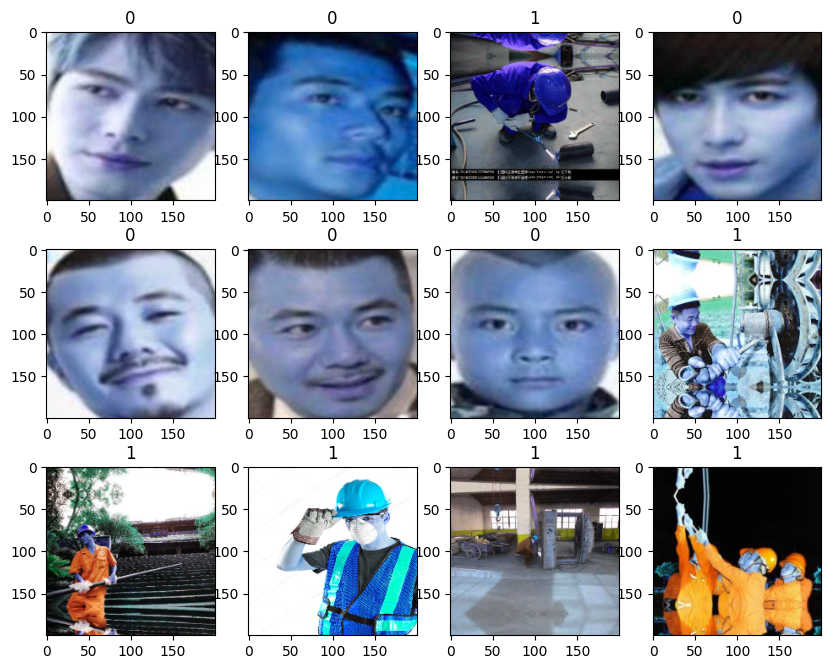

In [ ]:
#run the function to show the images
plot_images(rgb_images,labels)

* We can see from the images that the 0 label is for workers without helmets, and the 1 label is for workers with helmets. Due to those numerical assignments, the dataset defines workers with helmets as the "positive" class, and workers without helmets as the "negative" class.
* We can also observe that the negative class (no helmets) are often tight headshots, while the "positive" class (with helmets) are often wider shots -- at least a torso, if not wider.
* We can also observe that the negative class tends to have a distinct blue color for the person's skin, and that color makes up a big part of the image. Meantime, the positive class tends to have other colors -- vests, background, etc.
* The big differences between the positive and negative classes -- predominantly blue hues vs. other colors in the picture, headshots vs. wider shots -- may be easier for the model to learn than identifying whether someone is wearing a helmet in the picture, which is the goal. This may make achieving the task more difficult.
* The relatively small dataset may also make model development more challenging.

## Checking for class imbalance


In [ ]:
#check how many of each value there is in the labels csv
labels.value_counts()

Label
0        320
1        311
Name: count, dtype: int64

The classes are almost evenly balanced.

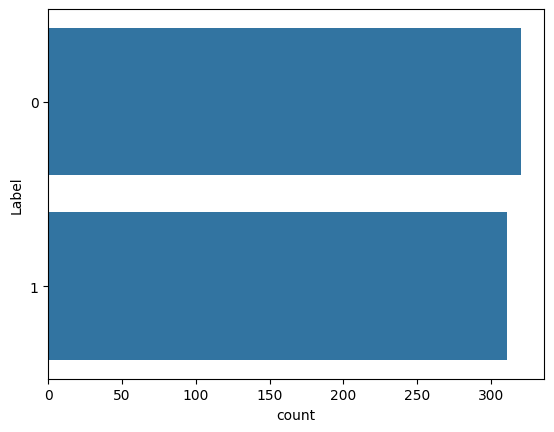

In [ ]:
#plot the classes
sns.countplot(data=labels, y = 'Label');

# **Data Preprocessing**

## Converting images to grayscale

In [ ]:
#loop through the color images and take each one, make it gray, and add it to gray_iamges
gray_images = []
for i in range(len(rgb_images)):
  gray_images.append(cv2.cvtColor(rgb_images[i], cv2.COLOR_RGB2GRAY))

In [ ]:
#function to show original and processed images side by side- from computer vision extra case study
def grid_plot(img1,img2,gray=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img1)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    if gray:
      axes[1].imshow(img2,cmap='gray')
    else:
      axes[1].imshow(img2)
    axes[1].set_title('Processed Image')
    axes[1].axis('off')

    plt.show()

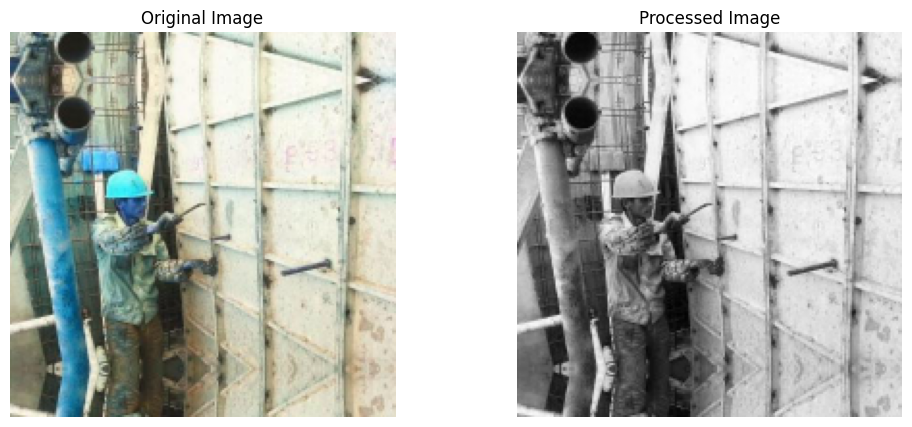

In [ ]:
# inspecting an image and its processed version
n = 3
# plotting the original and preprocessed image
grid_plot(rgb_images[n],gray_images[n],gray=True)

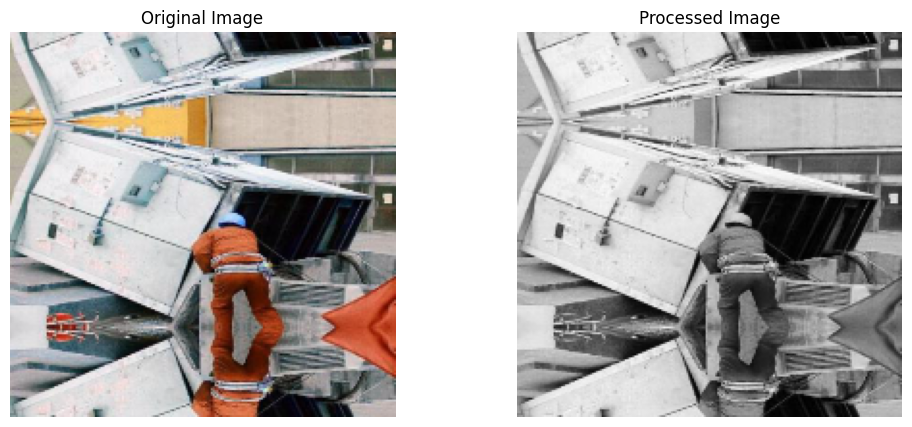

In [ ]:
# inspecting an image and its processed version
n = 46
# plotting the original and preprocessed image
grid_plot(rgb_images[n],gray_images[n],gray=True)

The color images are now grayscale in the new dataset.

### Splitting the dataset



Per CNN MLS notebook -- since we have a small dataset, we'll use 80% of the data for training, 10% for validation, and 10% for testing.

In [ ]:
#split the rgb dataset into train, val, and test
X_train_rgb, X_temp_rgb, y_train_rgb, y_temp_rgb = train_test_split(np.array(rgb_images), labels, test_size=0.2, random_state=42, stratify=labels)
X_val_rgb, X_test_rgb, y_val_rgb, y_test_rgb = train_test_split(X_temp_rgb, y_temp_rgb, test_size=0.5, random_state=42, stratify=y_temp_rgb)

In [ ]:
#split the gray dataset into train, val, and test
X_train_gray, X_temp_gray, y_train_gray, y_temp_gray = train_test_split(np.array(gray_images), labels, test_size=0.2, random_state=42, stratify=labels)
X_val_gray, X_test_gray, y_val_gray, y_test_gray = train_test_split(X_temp_gray, y_temp_gray, test_size=0.5, random_state=42, stratify=y_temp_gray)

In [ ]:
#check the sizes of the rgb datasets
print(X_train_rgb.shape, y_train_rgb.shape)
print(X_val_rgb.shape,y_val_rgb.shape)
print(X_test_rgb.shape,y_test_rgb.shape)

(504, 200, 200, 3) (504, 1)
(63, 200, 200, 3) (63, 1)
(64, 200, 200, 3) (64, 1)


In [ ]:
#check the sizes of the gray datasets
print(X_train_gray.shape, y_train_gray.shape)
print(X_val_gray.shape,y_val_gray.shape)
print(X_test_gray.shape,y_test_gray.shape)

(504, 200, 200) (504, 1)
(63, 200, 200) (63, 1)
(64, 200, 200) (64, 1)


For both the rgb and gray datasets, there are 504 images in the training dataset, 63 in the validation dataset, and 64 images in the test dataset. The images are all 200 x 200, as expected, with 3 channels for the color images. The label datasets all match their respective image datasets.

### Data Normalization

In [ ]:
#inspect a random pixel in a random image to see how pixel value looks before normalization
random_image = X_train_rgb[4]
random_image[100, 100]

array([163, 167, 243], dtype=uint8)

In [ ]:
# Normalizing the rgb image pixels
X_train_rgb_norm = X_train_rgb.astype('float32')/255.0
X_val_rgb_norm = X_val_rgb.astype('float32')/255.0
X_test_rgb_norm = X_test_rgb.astype('float32')/255.0

In [ ]:
#inspect the same pixel to see how it looks after normalization
random_image = X_train_rgb_norm[4]
random_image[100, 100]

array([0.6392157, 0.654902 , 0.9529412], dtype=float32)

The pixel value is now normalized.

In [ ]:
# Normalizing the gray image pixels
X_train_gray_norm = X_train_gray.astype('float32')/255.0
X_val_gray_norm = X_val_gray.astype('float32')/255.0
X_test_gray_norm = X_test_gray.astype('float32')/255.0

In [ ]:
#added channel dimension to normalized grayscale dataset-- model1 had errors until this was added
X_train_gray_norm = np.expand_dims(X_train_gray_norm, axis=-1)
X_val_gray_norm = np.expand_dims(X_val_gray_norm, axis=-1)
X_test_gray_norm = np.expand_dims(X_test_gray_norm, axis=-1)

In [ ]:
#create a three-channel version of the gray datasets for vgg
X_train_gray_norm_vgg = np.repeat(X_train_gray_norm, 3, axis = -1)
X_val_gray_norm_vgg = np.repeat(X_val_gray_norm, 3, axis = -1)
X_test_gray_norm_vgg = np.repeat(X_test_gray_norm, 3, axis = -1)

In [ ]:
#check that the vgg version of grayscale dataset has 3 channels
X_train_gray_norm_vgg.shape

(504, 200, 200, 3)

In [ ]:
#check that the vgg version of grayscale dataset has 3 channels
X_val_gray_norm_vgg.shape

(63, 200, 200, 3)

# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(modelpc, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = modelpc.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [ ]:
def plot_confusion_matrix(modelcm,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = modelcm.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
#function to plot loss/recall -- from neural network modules
def plot(history, name):
    """
    Function to plot loss/recall

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Recall
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train recall or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation recall or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

##Model 1, 2: Simple Convolutional Neural Network (CNN) with Gray and RGB

###Gray Images

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
#initialize the model
model1 = Sequential()

#add conv layer with 64 filters, kernel size 3x3, relu activation, "same" padding
#input shape params match the pixel size of input images, and 1 for grayscale
model1.add(Conv2D(64, (3, 3), padding="same", input_shape=(200, 200, 1)))

#batch norm
model1.add(BatchNormalization())

#activation function broken out so batch norm runs before
model1.add(Activation('relu'))

#max pooling on first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

#dropout
model1.add(Dropout(0.3))

#more conv, regularization layers
model1.add(Conv2D(32, (3, 3), padding="same"))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(Dropout(0.3))
model1.add(Conv2D(16, (3, 3), padding="same"))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(Dropout(0.3))

#flatten
model1.add(Flatten())

#ann
model1.add(Dense(128))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.4))
model1.add(Dense(64, activation = 'relu'))

#add output layer with 2 neurons and sigmoid for a binary classification problem
model1.add(Dense(1, activation='sigmoid'))

It is most important to identify the workers not wearing helmets, since corrective action needs to be taken upon their identification. Per the dataset, workers without helmets are the "negative" class (0), and workers with helmets are the "positive" class (1). So, we want to minimize "false positives", which would be workers predicted as wearing a helmet when they're not. So, we want to use precision as our metric.

In [ ]:
#binary crossentropy for binary target variable
optimizer = "adam"
model1.compile(loss="binary_crossentropy", optimizer = optimizer, metrics = ['precision'])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,137 (5.01 MB)

 Trainable params: 1,312,657 (5.01 MB)

 Non-trainable params: 480 (1.88 KB)

In [ ]:
#epochs
epochs = 20

#batch size
batch_size = 12

#fit model
history = model1.fit(X_train_gray_norm, y_train_gray, validation_data = (X_val_gray_norm, y_val_gray), epochs = epochs, batch_size = batch_size, shuffle = True, verbose = 2)

Epoch 1/20
42/42 - 10s - 243ms/step - loss: 0.2451 - precision: 0.9471 - val_loss: 1.8334 - val_precision: 0.0000e+00
Epoch 2/20
42/42 - 4s - 85ms/step - loss: 0.1249 - precision: 0.9916 - val_loss: 2.8716 - val_precision: 0.0000e+00
Epoch 3/20
42/42 - 4s - 85ms/step - loss: 0.0797 - precision: 0.9918 - val_loss: 3.7499 - val_precision: 0.0000e+00
Epoch 4/20
42/42 - 4s - 85ms/step - loss: 0.0561 - precision: 0.9918 - val_loss: 4.4001 - val_precision: 0.0000e+00
Epoch 5/20
42/42 - 4s - 85ms/step - loss: 0.0426 - precision: 0.9959 - val_loss: 4.3770 - val_precision: 0.0000e+00
Epoch 6/20
42/42 - 4s - 85ms/step - loss: 0.0416 - precision: 0.9960 - val_loss: 3.3040 - val_precision: 0.0000e+00
Epoch 7/20
42/42 - 4s - 85ms/step - loss: 0.0287 - precision: 0.9959 - val_loss: 3.9124 - val_precision: 0.0000e+00
Epoch 8/20
42/42 - 4s - 85ms/step - loss: 0.0164 - precision: 0.9960 - val_loss: 3.9238 - val_precision: 0.0000e+00
Epoch 9/20
42/42 - 4s - 85ms/step - loss: 0.0286 - precision: 0.9839 -

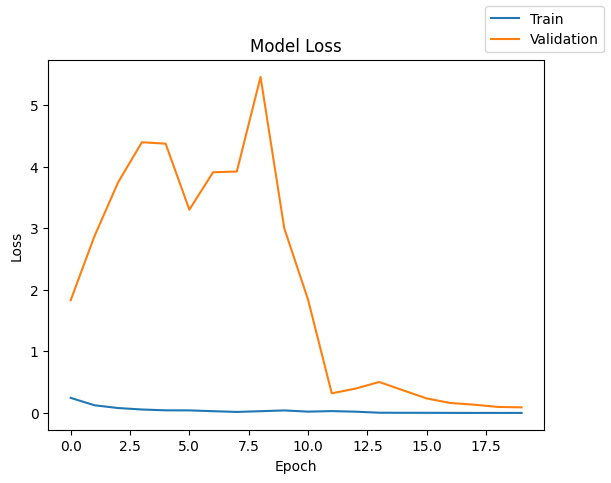

In [ ]:
#plot loss
plot(history, 'loss')

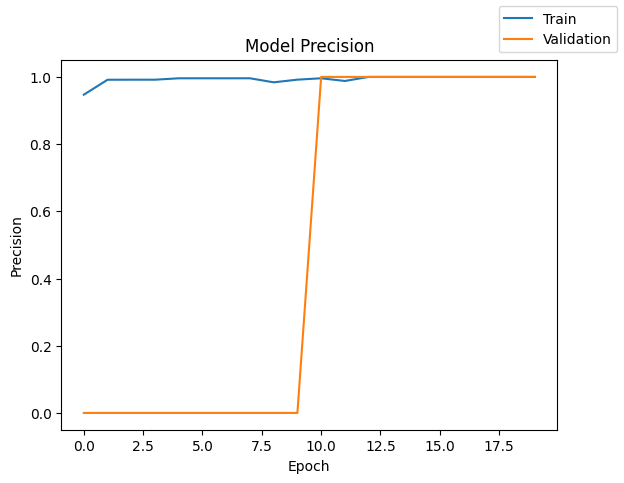

In [ ]:
#plot recall
plot(history, 'precision')

In [ ]:
#show eval metrics
model1_train_perf = model_performance_classification(model1, X_train_gray_norm, y_train_gray)
model1_train_perf.insert(0, "Name",  "Simple CNN Train Gray")

print("Train performance metrics")
print(model1_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Train performance metrics
                    Name  Accuracy    Recall  Precision  F1 Score
0  Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


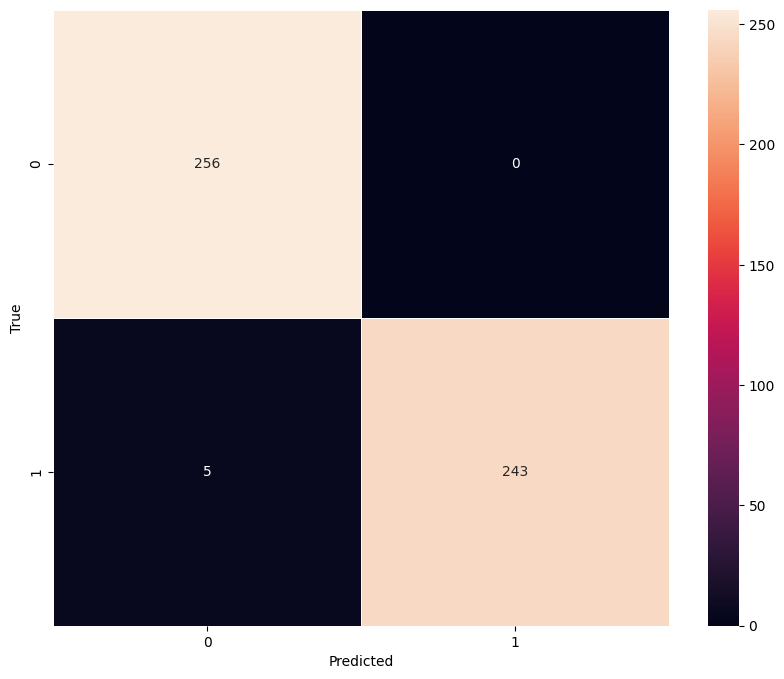

In [ ]:
#show confusion matrix
model1_train_cm = plot_confusion_matrix(model1, X_train_gray_norm, y_train_gray)

In [ ]:
#show eval metrics
model1_val_perf = model_performance_classification(model1, X_val_gray_norm, y_val_gray)
model1_val_perf.insert(0, "Name",  "Simple CNN Val Gray")
print("Validation performance metrics")
print(model1_val_perf)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Validation performance metrics
                  Name  Accuracy    Recall  Precision  F1 Score
0  Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


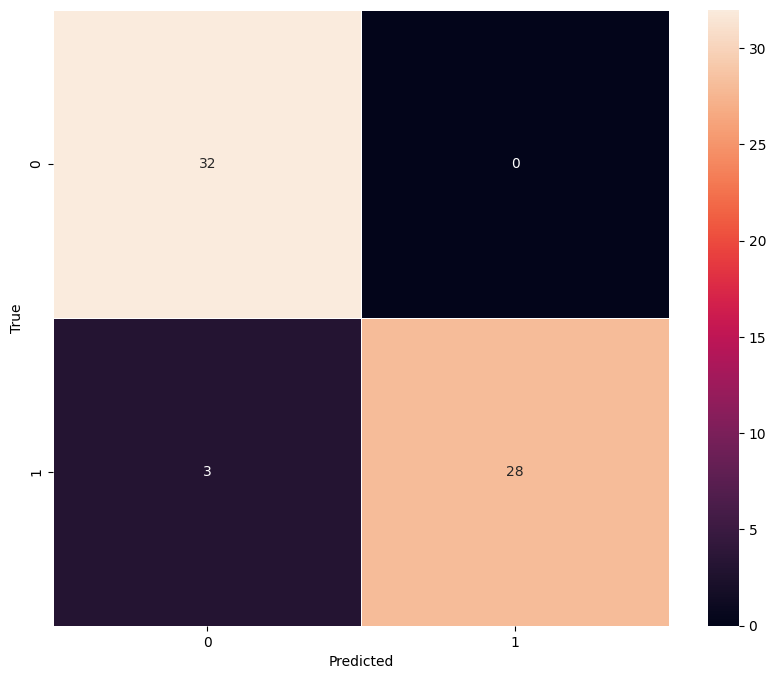

In [ ]:
#show confusion matrix
model1_val_cm = plot_confusion_matrix(model1, X_val_gray_norm, y_val_gray)

In [ ]:
#put the model's train and val scores in a df
results = pd.concat([model1_train_perf, model1_val_perf], axis = 0)
results

Name  Accuracy    Recall  Precision  F1 Score
0  Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077
0    Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236

It took Model 1 about 11 epochs to reduce its loss score substantially, and about 9-10 epochs for its precision to top out at a perfect score. The wrong predictions were false negatives (predict a worker was not wearing a helmet when they were) -- which are less costly errors than the false positives we're trying to avoid.

#### Vizualizing the predictions

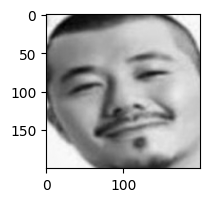

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted:  [[0]]
Truth: Label    0
Name: 603, dtype: int64


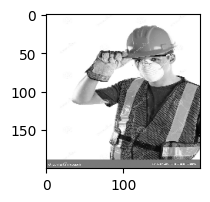

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 160, dtype: int64


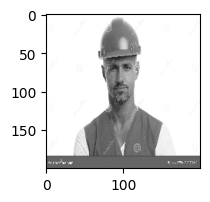

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 113, dtype: int64


In [ ]:
# Visualizing the predicted and correct labels of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm[2], cmap = 'gray')
plt.show()
imgpred1 = model1.predict(X_val_gray_norm[2].reshape(1,200,200,1))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_gray.iloc[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm[14], cmap = 'gray')
plt.show()
imgpred1 = model1.predict(X_val_gray_norm[14].reshape(1,200,200,1))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_gray.iloc[14])

plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm[41], cmap = 'gray')
plt.show()
imgpred1 = model1.predict(X_val_gray_norm[41].reshape(1,200,200,1))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_gray.iloc[41])

We can observe that the workers with helmets are generally wider shots, while the workers without helmets are generally tighter shots. This has been the case with the other images we've seen. All the images seen here were correct predictions.

###RGB Images

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
#initialize the model
model2 = Sequential()

#add conv layer with 64 filters, kernel size 3x3, relu activation, "same" padding
#input shape params match the pixel size of input images, and 3 for color
model2.add(Conv2D(64, (3, 3), padding="same", input_shape=(200, 200, 3)))

#batch norm
model2.add(BatchNormalization())

#activation function broken out so batch norm runs before
model2.add(Activation('relu'))

#max pooling on first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

#dropout
model2.add(Dropout(0.3))

#more conv, regularization layers
model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(Dropout(0.3))
model2.add(Conv2D(16, (3, 3), padding="same"))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(Dropout(0.3))

#flatten
model2.add(Flatten())

#ann
model2.add(Dense(128))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.4))
model2.add(Dense(64, activation = 'relu'))

#add output layer with 2 neurons and sigmoid for a binary classification problem
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
#binary crossentropy for binary target variable
optimizer = "adam"
model2.compile(loss="binary_crossentropy", optimizer = optimizer, metrics = ['precision'])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,289 (5.01 MB)

 Trainable params: 1,313,809 (5.01 MB)

 Non-trainable params: 480 (1.88 KB)

In [ ]:
#epochs
epochs = 20

#batch size
batch_size = 12

#fit model
history = model2.fit(X_train_rgb_norm, y_train_rgb, validation_data = (X_val_rgb_norm, y_val_rgb), epochs = epochs, batch_size = batch_size, shuffle = True, verbose = 2)

Epoch 1/20
42/42 - 7s - 173ms/step - loss: 0.1613 - precision: 0.9506 - val_loss: 1.9589 - val_precision: 0.0000e+00
Epoch 2/20
42/42 - 4s - 88ms/step - loss: 0.0975 - precision: 0.9876 - val_loss: 3.0754 - val_precision: 0.0000e+00
Epoch 3/20
42/42 - 4s - 88ms/step - loss: 0.0659 - precision: 0.9837 - val_loss: 3.5381 - val_precision: 0.0000e+00
Epoch 4/20
42/42 - 4s - 88ms/step - loss: 0.0563 - precision: 0.9878 - val_loss: 4.2385 - val_precision: 0.0000e+00
Epoch 5/20
42/42 - 4s - 89ms/step - loss: 0.0627 - precision: 0.9798 - val_loss: 3.7398 - val_precision: 0.0000e+00
Epoch 6/20
42/42 - 4s - 89ms/step - loss: 0.0483 - precision: 0.9878 - val_loss: 3.8964 - val_precision: 0.0000e+00
Epoch 7/20
42/42 - 4s - 89ms/step - loss: 0.0288 - precision: 0.9959 - val_loss: 3.7046 - val_precision: 0.0000e+00
Epoch 8/20
42/42 - 4s - 89ms/step - loss: 0.0147 - precision: 0.9960 - val_loss: 3.1445 - val_precision: 0.0000e+00
Epoch 9/20
42/42 - 4s - 88ms/step - loss: 0.0152 - precision: 1.0000 - 

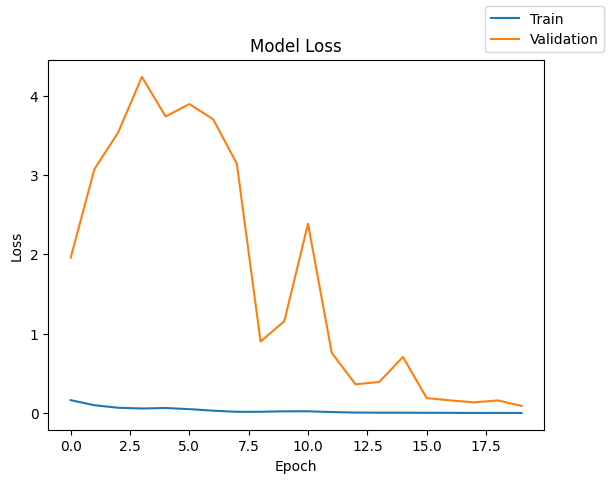

In [ ]:
#plot loss
plot(history, 'loss')

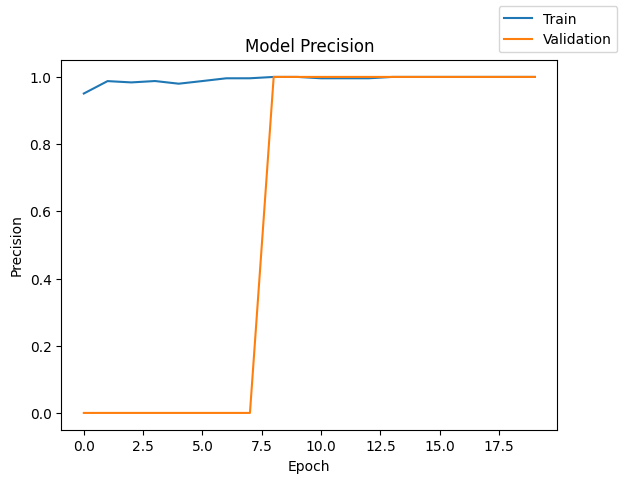

In [ ]:
#plot recall
plot(history, 'precision')

In [ ]:
#show eval metrics
model2_train_perf = model_performance_classification(model2, X_train_rgb_norm, y_train_rgb)
model2_train_perf.insert(0, "Name",  "Simple CNN Train RGB")

print("Train performance metrics")
print(model2_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Train performance metrics
                   Name  Accuracy    Recall  Precision  F1 Score
0  Simple CNN Train RGB  0.990079  0.990079   0.990269  0.990077


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


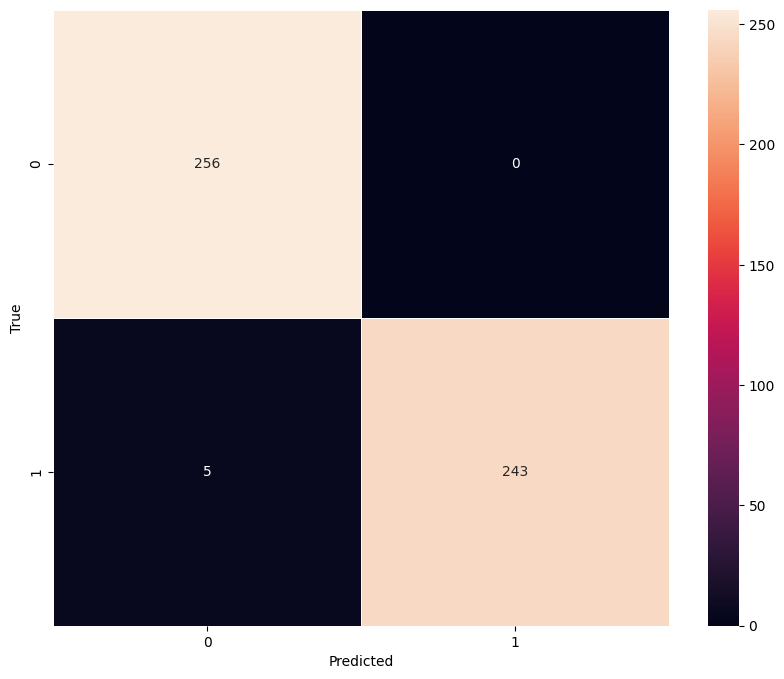

In [ ]:
#show confusion matrix
model2_train_cm = plot_confusion_matrix(model2, X_train_rgb_norm, y_train_rgb)

In [ ]:
#show eval metrics
model2_val_perf = model_performance_classification(model2, X_val_rgb_norm, y_val_rgb)
model2_val_perf.insert(0, "Name",  "Simple CNN Val RGB")
print("Validation performance metrics")
print(model2_val_perf)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Validation performance metrics
                 Name  Accuracy    Recall  Precision  F1 Score
0  Simple CNN Val RGB  0.968254  0.968254   0.970121  0.968206


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


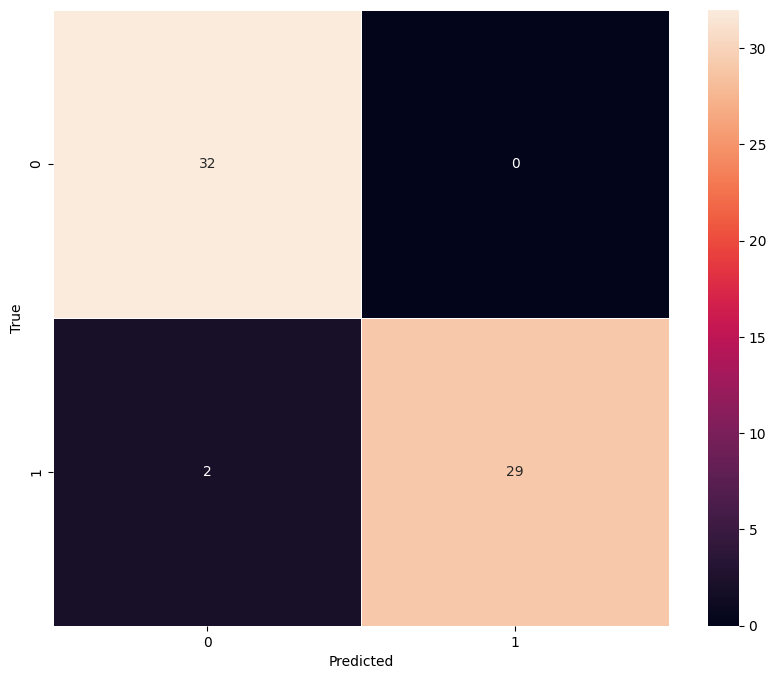

In [ ]:
#show confusion matrix
model2_val_cm = plot_confusion_matrix(model2, X_val_rgb_norm, y_val_rgb)

In [ ]:
results = pd.concat([results, model2_train_perf, model2_val_perf], axis = 0)
results

Name  Accuracy    Recall  Precision  F1 Score
0  Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077
0    Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236
0   Simple CNN Train RGB  0.990079  0.990079   0.990269  0.990077
0     Simple CNN Val RGB  0.968254  0.968254   0.970121  0.968206

Model 2 performed better on the validation set than Model 1 -- meaning the model could rely on color to differentiate between the two classes. Model 2 also was able to reduce its loss and increase its precision in fewer epochs than Model 1.

#### Vizualizing the predictions

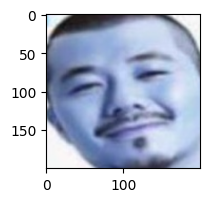

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted:  [[0]]
Truth: Label    0
Name: 603, dtype: int64


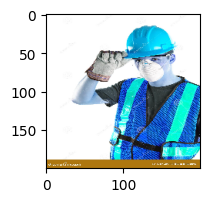

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 160, dtype: int64


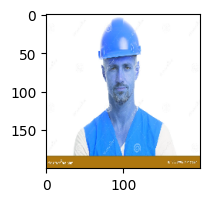

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted:  [[0]]
Truth: Label    1
Name: 113, dtype: int64


In [ ]:
# Visualizing the predicted and correct labels of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[2])
plt.show()
imgpred1 = model2.predict(X_val_rgb_norm[2].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[14])
plt.show()
imgpred1 = model2.predict(X_val_rgb_norm[14].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[14])

plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[41])
plt.show()
imgpred1 = model2.predict(X_val_rgb_norm[41].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[41])

In this case, one of the images is a false negative.

## Model 3, 4: VGG-16 (Base) with Gray and RGB

In [ ]:
#initialize the vgg model -- leaving the ann out
vgg_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(200, 200, 3))
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#freezing the vgg layers
for layer in vgg_model.layers:
    layer.trainable = False

###Gray Images

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
#initialize model3
model3 = Sequential()

#add vgg's convolutional layers
model3.add(vgg_model)

#flatten vgg's convolutional output
model3.add(Flatten())

#add output layer with 2 neurons and sigmoid for a binary classification problem
model3.add(Dense(1, activation='sigmoid'))

In [ ]:
#binary crossentropy for binary target variable
optimizer = "adam"
model3.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['precision'])
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#epochs
epochs = 20

#batch size
batch_size = 12

#fit model
history = model3.fit(X_train_gray_norm_vgg, y_train_gray, validation_data = (X_val_gray_norm_vgg, y_val_gray), epochs = epochs, batch_size = batch_size, shuffle = True, verbose = 2)

Epoch 1/20
42/42 - 4s - 104ms/step - loss: 0.1205 - precision: 0.9373 - val_loss: 0.0108 - val_precision: 1.0000
Epoch 2/20
42/42 - 3s - 64ms/step - loss: 0.0049 - precision: 1.0000 - val_loss: 0.0051 - val_precision: 1.0000
Epoch 3/20
42/42 - 3s - 65ms/step - loss: 0.0029 - precision: 1.0000 - val_loss: 0.0042 - val_precision: 1.0000
Epoch 4/20
42/42 - 3s - 65ms/step - loss: 0.0021 - precision: 1.0000 - val_loss: 0.0035 - val_precision: 1.0000
Epoch 5/20
42/42 - 3s - 66ms/step - loss: 0.0017 - precision: 1.0000 - val_loss: 0.0030 - val_precision: 1.0000
Epoch 6/20
42/42 - 3s - 66ms/step - loss: 0.0013 - precision: 1.0000 - val_loss: 0.0026 - val_precision: 1.0000
Epoch 7/20
42/42 - 3s - 67ms/step - loss: 0.0011 - precision: 1.0000 - val_loss: 0.0023 - val_precision: 1.0000
Epoch 8/20
42/42 - 3s - 67ms/step - loss: 9.3877e-04 - precision: 1.0000 - val_loss: 0.0021 - val_precision: 1.0000
Epoch 9/20
42/42 - 3s - 67ms/step - loss: 8.0347e-04 - precision: 1.0000 - val_loss: 0.0019 - val_p

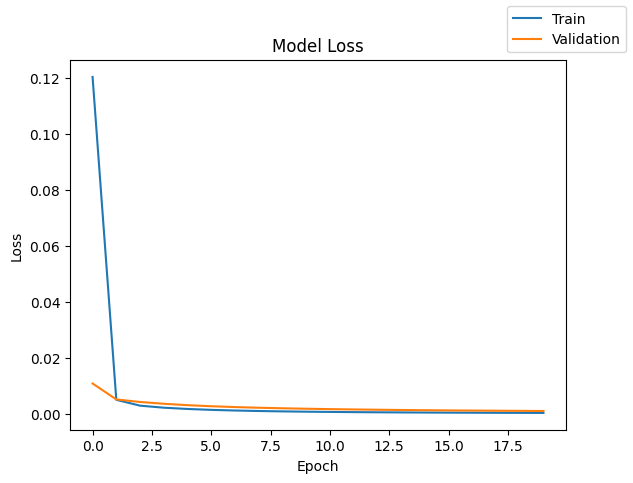

In [ ]:
#plot loss
plot(history, 'loss')

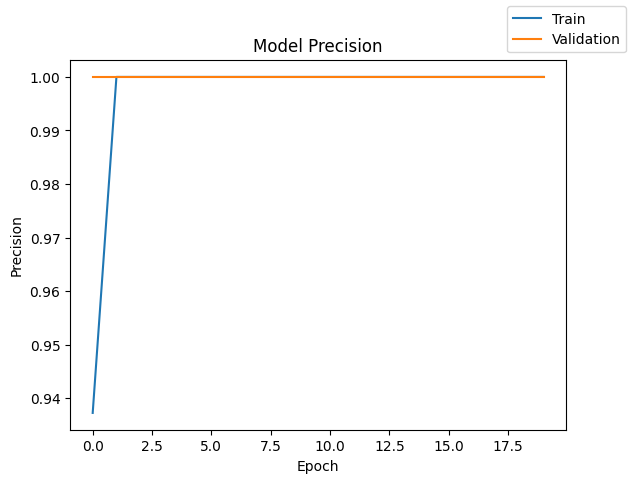

In [ ]:
#plot recall
plot(history, 'precision')

In [ ]:
#show eval metrics
model3_train_perf = model_performance_classification(model3, X_train_gray_norm_vgg, y_train_gray)
model3_train_perf.insert(0, "Name",  "VGG Base Train Gray")

print("Train performance metrics")
print(model3_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step
Train performance metrics
                  Name  Accuracy  Recall  Precision  F1 Score
0  VGG Base Train Gray       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


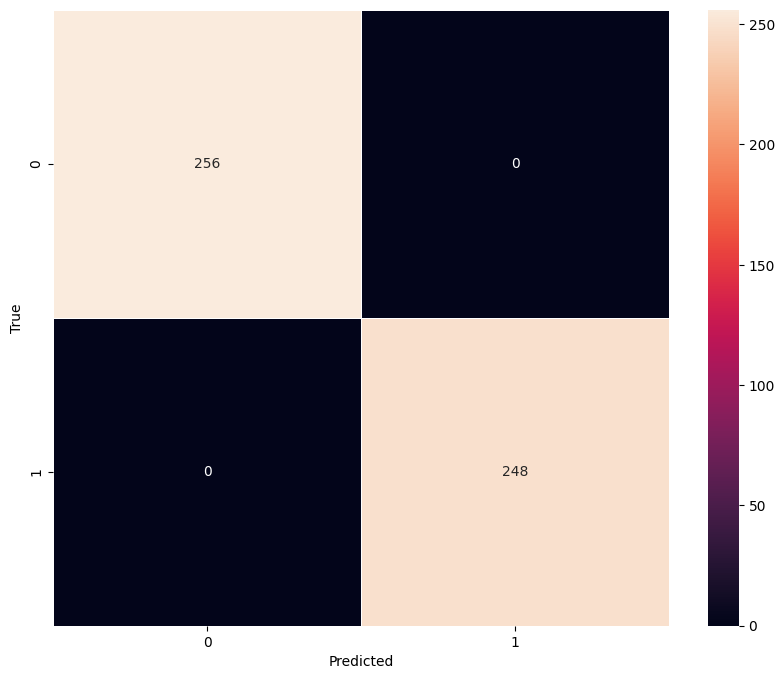

In [ ]:
#show confusion matrix
model3_train_cm = plot_confusion_matrix(model3, X_train_rgb_norm, y_train_rgb)

In [ ]:
#show eval metrics
model3_val_perf = model_performance_classification(model3, X_val_gray_norm_vgg, y_val_gray)
model3_val_perf.insert(0, "Name",  "VGG Base Val Gray")
print("Validation performance metrics")
print(model3_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Validation performance metrics
                Name  Accuracy  Recall  Precision  F1 Score
0  VGG Base Val Gray       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


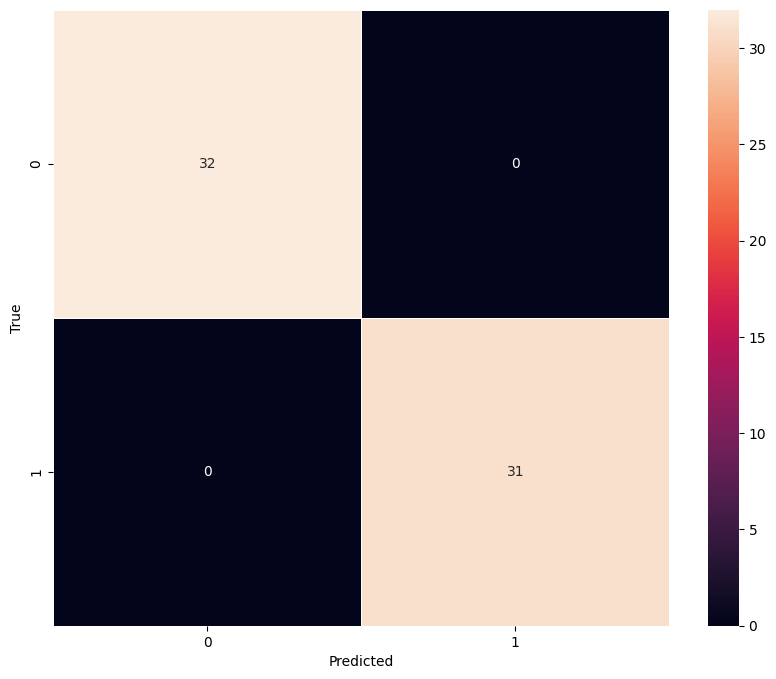

In [ ]:
#show confusion matrix
model3_val_cm = plot_confusion_matrix(model3, X_val_rgb_norm, y_val_rgb)

In [ ]:
results = pd.concat([results, model3_train_perf, model3_val_perf], axis = 0)
results

Name  Accuracy    Recall  Precision  F1 Score
0  Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077
0    Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236
0   Simple CNN Train RGB  0.990079  0.990079   0.990269  0.990077
0     Simple CNN Val RGB  0.968254  0.968254   0.970121  0.968206
0    VGG Base Train Gray  1.000000  1.000000   1.000000  1.000000
0      VGG Base Val Gray  1.000000  1.000000   1.000000  1.000000

Model 3 with VGG achieved perfect scores on the train and validation datasets, and had a minimal loss score within 2 epochs on both datasets. I would normally be concerned with overfitting -- but it is possible that the model is learning to differentiate between the wide shots and the tight shots on workers, which is likely easy for the model to figure out.

#### Visualizing the prediction:

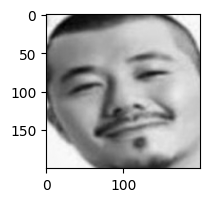

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted:  [[0]]
Truth: Label    0
Name: 603, dtype: int64


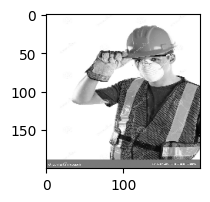

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 160, dtype: int64


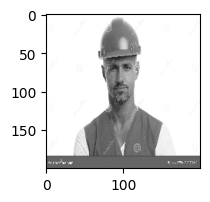

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 113, dtype: int64


In [ ]:
# Visualizing the predicted and correct labels of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm[2], cmap = 'gray')
plt.show()
imgpred1 = model3.predict(X_val_gray_norm_vgg[2].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_gray.iloc[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm[14], cmap = 'gray')
plt.show()
imgpred1 = model3.predict(X_val_gray_norm_vgg[14].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_gray.iloc[14])

plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm[41], cmap = 'gray')
plt.show()
imgpred1 = model3.predict(X_val_gray_norm_vgg[41].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_gray.iloc[41])

This time, all the images are correct predictions.

###RGB Images

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
#initialize model4
model4 = Sequential()

#add vgg's convolutional layers
model4.add(vgg_model)

#flatten vgg's convolutional output
model4.add(Flatten())

#add output layer with 2 neurons and sigmoid for a binary classification problem
model4.add(Dense(1, activation='sigmoid'))

In [ ]:
#binary crossentropy for binary target variable
optimizer = "adam"
model4.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['precision'])
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#epochs
epochs = 20

#batch size
batch_size = 12

#fit model
history = model4.fit(X_train_rgb_norm, y_train_rgb, validation_data = (X_val_rgb_norm, y_val_rgb), epochs = epochs, batch_size = batch_size, shuffle = True, verbose = 2)

Epoch 1/20
42/42 - 4s - 103ms/step - loss: 0.0871 - precision: 0.9500 - val_loss: 0.0048 - val_precision: 1.0000
Epoch 2/20
42/42 - 3s - 64ms/step - loss: 0.0030 - precision: 1.0000 - val_loss: 0.0030 - val_precision: 1.0000
Epoch 3/20
42/42 - 3s - 65ms/step - loss: 0.0020 - precision: 1.0000 - val_loss: 0.0023 - val_precision: 1.0000
Epoch 4/20
42/42 - 3s - 65ms/step - loss: 0.0014 - precision: 1.0000 - val_loss: 0.0019 - val_precision: 1.0000
Epoch 5/20
42/42 - 3s - 65ms/step - loss: 0.0011 - precision: 1.0000 - val_loss: 0.0017 - val_precision: 1.0000
Epoch 6/20
42/42 - 3s - 65ms/step - loss: 8.8221e-04 - precision: 1.0000 - val_loss: 0.0015 - val_precision: 1.0000
Epoch 7/20
42/42 - 3s - 66ms/step - loss: 7.3142e-04 - precision: 1.0000 - val_loss: 0.0013 - val_precision: 1.0000
Epoch 8/20
42/42 - 3s - 66ms/step - loss: 6.1825e-04 - precision: 1.0000 - val_loss: 0.0012 - val_precision: 1.0000
Epoch 9/20
42/42 - 3s - 66ms/step - loss: 5.3079e-04 - precision: 1.0000 - val_loss: 0.0011

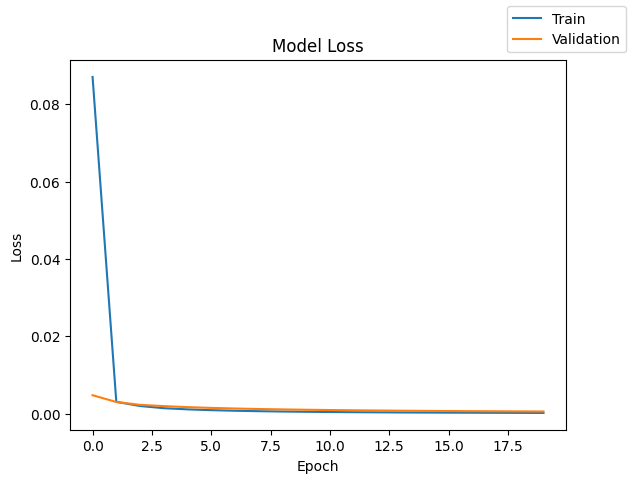

In [ ]:
#plot loss
plot(history, 'loss')

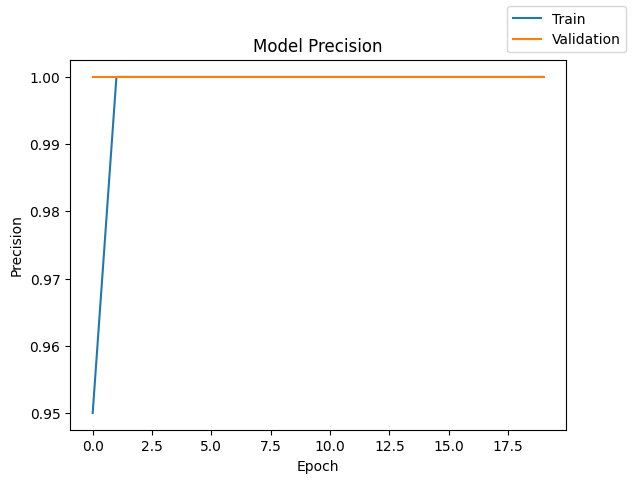

In [ ]:
#plot recall
plot(history, 'precision')

In [ ]:
#show eval metrics
model4_train_perf = model_performance_classification(model4, X_train_rgb_norm, y_train_rgb)
model4_train_perf.insert(0, "Name",  "VGG Base Train RGB")

print("Train performance metrics")
print(model4_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
Train performance metrics
                 Name  Accuracy  Recall  Precision  F1 Score
0  VGG Base Train RGB       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


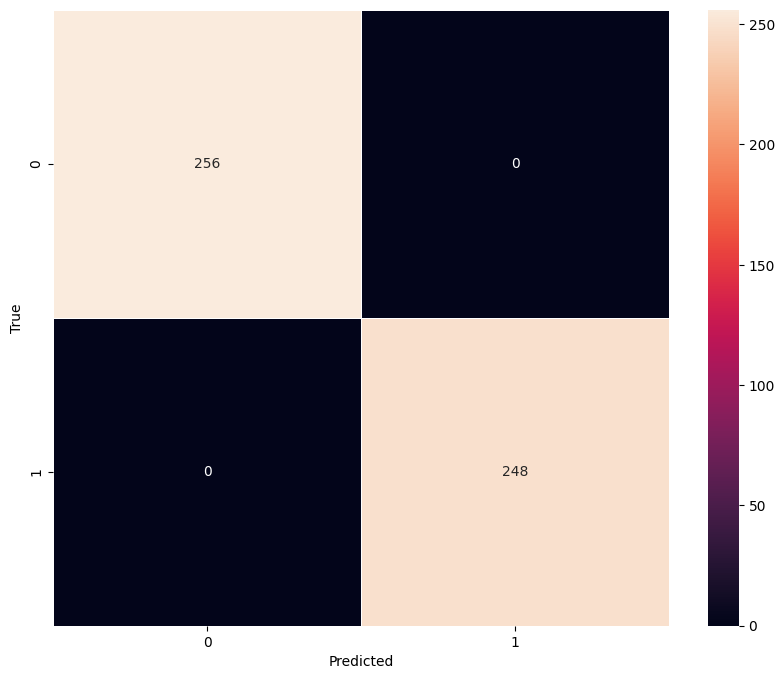

In [ ]:
#show confusion matrix
model4_train_cm = plot_confusion_matrix(model4, X_train_rgb_norm, y_train_rgb)

In [ ]:
#show eval metrics
model4_val_perf = model_performance_classification(model4, X_val_rgb_norm, y_val_rgb)
model4_val_perf.insert(0, "Name",  "VGG Base Val RGB")
print("Validation performance metrics")
print(model4_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Validation performance metrics
               Name  Accuracy  Recall  Precision  F1 Score
0  VGG Base Val RGB       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


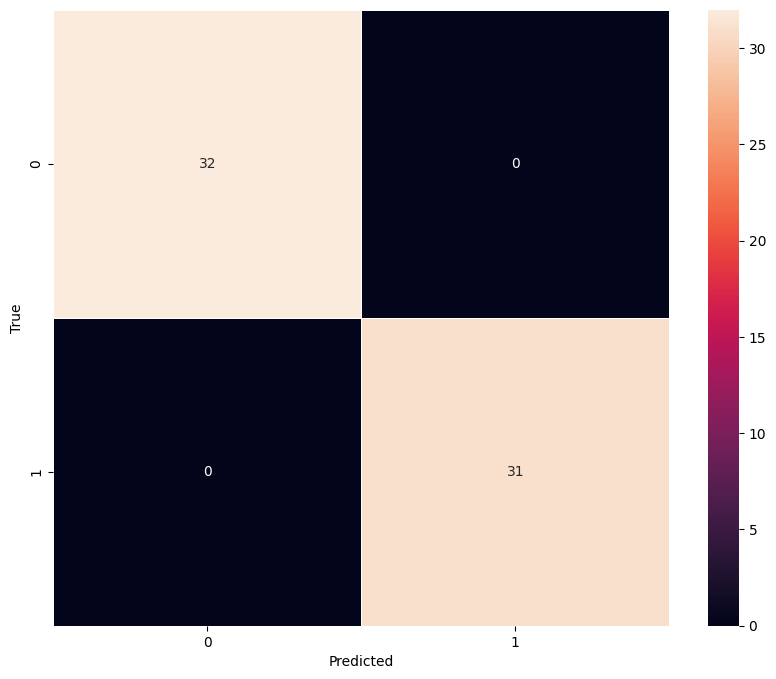

In [ ]:
#show confusion matrix
model4_val_cm = plot_confusion_matrix(model4, X_val_rgb_norm, y_val_rgb)

In [ ]:
results = pd.concat([results, model4_train_perf, model4_val_perf], axis = 0)
results

Name  Accuracy    Recall  Precision  F1 Score
0  Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077
0    Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236
0   Simple CNN Train RGB  0.990079  0.990079   0.990269  0.990077
0     Simple CNN Val RGB  0.968254  0.968254   0.970121  0.968206
0    VGG Base Train Gray  1.000000  1.000000   1.000000  1.000000
0      VGG Base Val Gray  1.000000  1.000000   1.000000  1.000000
0     VGG Base Train RGB  1.000000  1.000000   1.000000  1.000000
0       VGG Base Val RGB  1.000000  1.000000   1.000000  1.000000

As with Model 3, Model 4 achieved perfect scores and minimal loss within two epochs.

#### Visualizing the prediction:

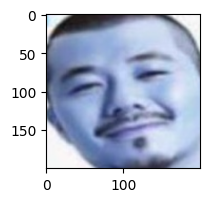

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted:  [[0]]
Truth: Label    0
Name: 603, dtype: int64


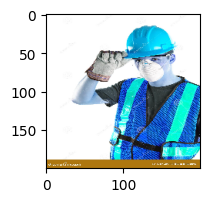

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 160, dtype: int64


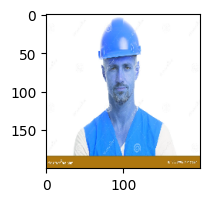

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 113, dtype: int64


In [ ]:
# Visualizing the predicted and correct labels of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[2])
plt.show()
imgpred1 = model4.predict(X_val_rgb_norm[2].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[14])
plt.show()
imgpred1 = model4.predict(X_val_rgb_norm[14].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[14])

plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[41])
plt.show()
imgpred1 = model4.predict(X_val_rgb_norm[41].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[41])

All three images are correct predictions once again.

## Model 5, 6: VGG-16 (Base + FFNN) with Gray and RGB

###Gray Images

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
#initialize model5
model5 = Sequential()

#add vgg's convolutional layers
model5.add(vgg_model)

#flatten vgg's convolutional output
model5.add(Flatten())

#ann
model5.add(Dense(128, activation = 'relu'))
model5.add(Dropout(rate=0.4))
model5.add(Dense(64, activation = 'relu'))

#add output layer with 2 neurons and sigmoid for a binary classification problem
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
#binary crossentropy for binary target variable
optimizer = "adam"
model5.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['precision'])
model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,082,433 (65.16 MB)

 Trainable params: 2,367,745 (9.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#epochs
epochs = 20

#batch size
batch_size = 12

#fit model
history = model5.fit(X_train_gray_norm_vgg, y_train_gray, validation_data = (X_val_gray_norm_vgg, y_val_gray), epochs = epochs, batch_size = batch_size, shuffle = True, verbose = 2)

Epoch 1/20
42/42 - 5s - 115ms/step - loss: 0.1832 - precision: 0.9261 - val_loss: 0.0042 - val_precision: 1.0000
Epoch 2/20
42/42 - 3s - 66ms/step - loss: 0.0040 - precision: 1.0000 - val_loss: 2.1038e-04 - val_precision: 1.0000
Epoch 3/20
42/42 - 3s - 66ms/step - loss: 0.0011 - precision: 1.0000 - val_loss: 2.1204e-05 - val_precision: 1.0000
Epoch 4/20
42/42 - 3s - 67ms/step - loss: 7.3070e-04 - precision: 1.0000 - val_loss: 1.1050e-05 - val_precision: 1.0000
Epoch 5/20
42/42 - 3s - 67ms/step - loss: 0.0044 - precision: 1.0000 - val_loss: 3.9066e-04 - val_precision: 1.0000
Epoch 6/20
42/42 - 3s - 67ms/step - loss: 0.0018 - precision: 1.0000 - val_loss: 1.8179e-04 - val_precision: 1.0000
Epoch 7/20
42/42 - 3s - 67ms/step - loss: 0.0027 - precision: 1.0000 - val_loss: 8.6555e-05 - val_precision: 1.0000
Epoch 8/20
42/42 - 3s - 67ms/step - loss: 0.0018 - precision: 1.0000 - val_loss: 1.4640e-04 - val_precision: 1.0000
Epoch 9/20
42/42 - 3s - 68ms/step - loss: 0.0014 - precision: 1.0000 - 

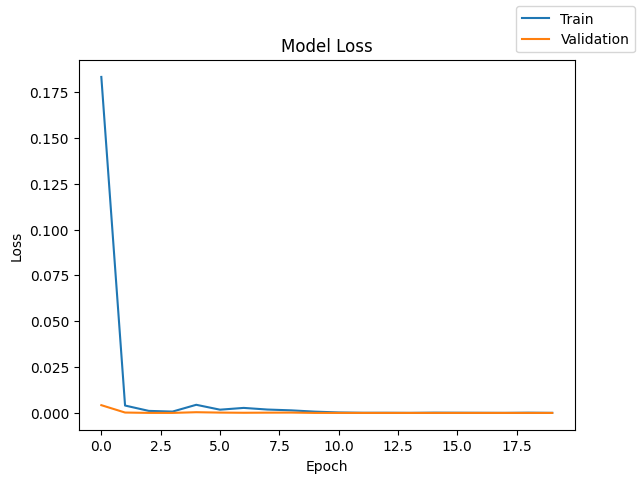

In [ ]:
#plot loss
plot(history, 'loss')

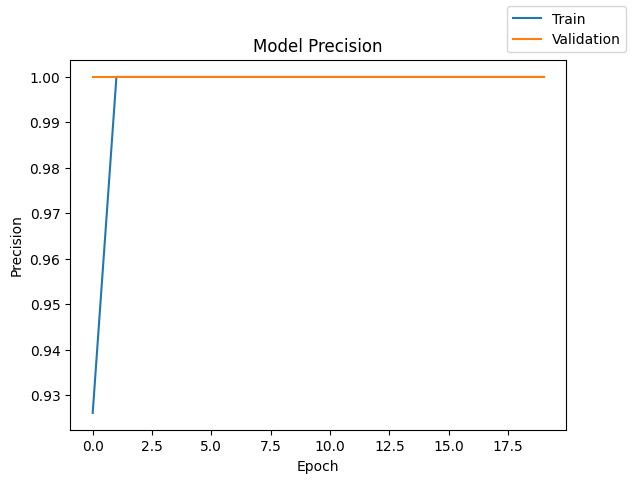

In [ ]:
#plot recall
plot(history, 'precision')

In [ ]:
#show eval metrics
model5_train_perf = model_performance_classification(model5, X_train_gray_norm_vgg, y_train_gray)
model5_train_perf.insert(0, "Name",  "VGG Base w/ANN Train Gray")

print("Train performance metrics")
print(model5_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
Train performance metrics
                        Name  Accuracy  Recall  Precision  F1 Score
0  VGG Base w/ANN Train Gray       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


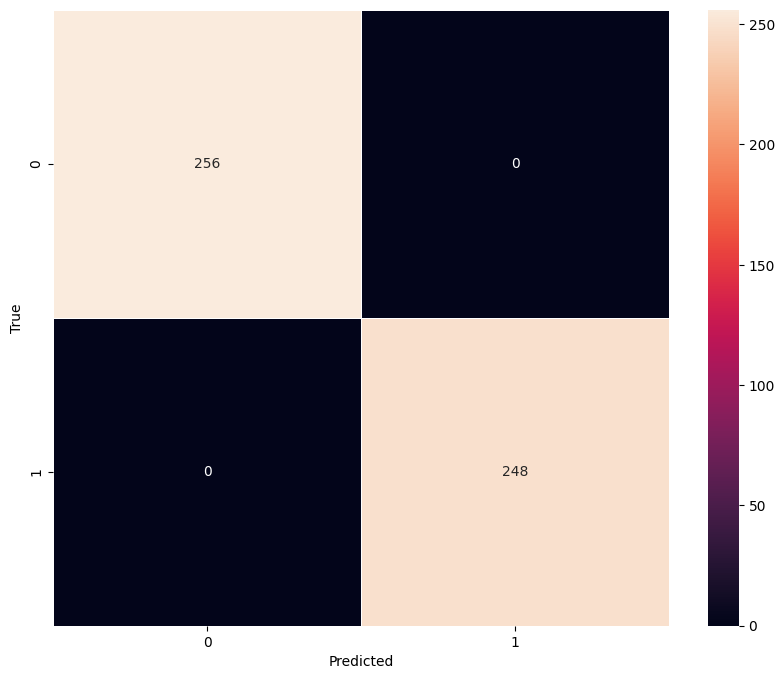

In [ ]:
#show confusion matrix
model5_train_cm = plot_confusion_matrix(model5, X_train_rgb_norm, y_train_rgb)

In [ ]:
#show eval metrics
model5_val_perf = model_performance_classification(model5, X_val_gray_norm_vgg, y_val_gray)
model5_val_perf.insert(0, "Name",  "VGG w/ANN Val Gray")
print("Validation performance metrics")
print(model5_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Validation performance metrics
                 Name  Accuracy  Recall  Precision  F1 Score
0  VGG w/ANN Val Gray       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


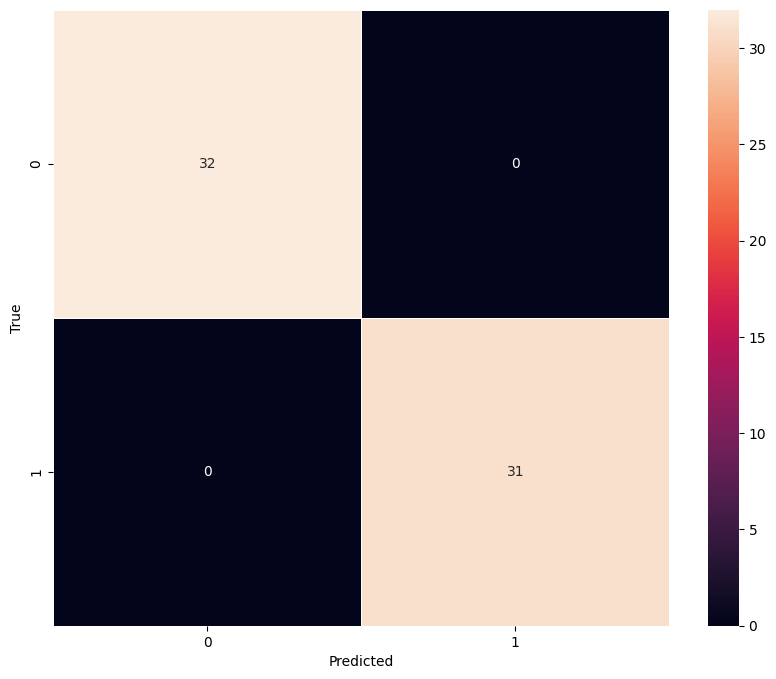

In [ ]:
#show confusion matrix
model5_val_cm = plot_confusion_matrix(model5, X_val_rgb_norm, y_val_rgb)

In [ ]:
results = pd.concat([results, model5_train_perf, model5_val_perf], axis = 0)
results

Name  Accuracy    Recall  Precision  F1 Score
0      Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077
0        Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236
0       Simple CNN Train RGB  0.990079  0.990079   0.990269  0.990077
0         Simple CNN Val RGB  0.968254  0.968254   0.970121  0.968206
0        VGG Base Train Gray  1.000000  1.000000   1.000000  1.000000
0          VGG Base Val Gray  1.000000  1.000000   1.000000  1.000000
0         VGG Base Train RGB  1.000000  1.000000   1.000000  1.000000
0           VGG Base Val RGB  1.000000  1.000000   1.000000  1.000000
0  VGG Base w/ANN Train Gray  1.000000  1.000000   1.000000  1.000000
0         VGG w/ANN Val Gray  1.000000  1.000000   1.000000  1.000000

Like Models 3 and 4, Model 5 has achieved perfect scores and minimal losses within two epochs, though it did have a small spike in loss around epoch 4.

#### Visualizing the prediction:

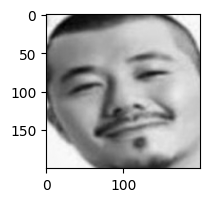

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted:  [[0]]
Truth: Label    0
Name: 603, dtype: int64


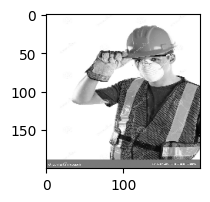

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 160, dtype: int64


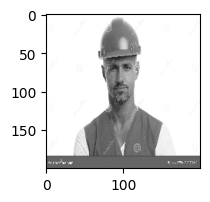

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 113, dtype: int64


In [ ]:
# Visualizing the predicted and correct labels of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm[2], cmap = 'gray')
plt.show()
imgpred1 = model5.predict(X_val_gray_norm_vgg[2].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_gray.iloc[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm[14], cmap = 'gray')
plt.show()
imgpred1 = model5.predict(X_val_gray_norm_vgg[14].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_gray.iloc[14])

plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm[41], cmap = 'gray')
plt.show()
imgpred1 = model5.predict(X_val_gray_norm_vgg[41].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_gray.iloc[41])

All three images were correct predictions.

###RGB Images

In [ ]:
#initialize model6
model6 = Sequential()

#add vgg's convolutional layers
model6.add(vgg_model)

#flatten vgg's convolutional output
model6.add(Flatten())

#ann
model6.add(Dense(128, activation = 'relu'))
model6.add(Dropout(rate=0.4))
model6.add(Dense(64, activation = 'relu'))

#add output layer with 2 neurons and sigmoid for a binary classification problem
model6.add(Dense(1, activation='sigmoid'))

In [ ]:
#binary crossentropy for binary target variable
optimizer = "adam"
model6.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['precision'])
model6.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,082,433 (65.16 MB)

 Trainable params: 2,367,745 (9.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#epochs
epochs = 20

#batch size
batch_size = 12

#fit model
history = model6.fit(X_train_rgb_norm, y_train_rgb, validation_data = (X_val_rgb_norm, y_val_rgb), epochs = epochs, batch_size = batch_size, shuffle = True, verbose = 2)

Epoch 1/20
42/42 - 5s - 114ms/step - loss: 0.2084 - precision: 0.9120 - val_loss: 4.3316e-04 - val_precision: 1.0000
Epoch 2/20
42/42 - 3s - 66ms/step - loss: 0.0089 - precision: 0.9920 - val_loss: 3.1444e-04 - val_precision: 1.0000
Epoch 3/20
42/42 - 3s - 66ms/step - loss: 0.0043 - precision: 0.9960 - val_loss: 1.1344e-04 - val_precision: 1.0000
Epoch 4/20
42/42 - 3s - 66ms/step - loss: 0.0044 - precision: 0.9960 - val_loss: 3.3287e-05 - val_precision: 1.0000
Epoch 5/20
42/42 - 3s - 67ms/step - loss: 0.0013 - precision: 1.0000 - val_loss: 2.1439e-05 - val_precision: 1.0000
Epoch 6/20
42/42 - 3s - 67ms/step - loss: 4.9703e-04 - precision: 1.0000 - val_loss: 1.3099e-05 - val_precision: 1.0000
Epoch 7/20
42/42 - 3s - 67ms/step - loss: 4.3538e-04 - precision: 1.0000 - val_loss: 9.7564e-06 - val_precision: 1.0000
Epoch 8/20
42/42 - 3s - 68ms/step - loss: 5.3393e-04 - precision: 1.0000 - val_loss: 8.1823e-06 - val_precision: 1.0000
Epoch 9/20
42/42 - 3s - 68ms/step - loss: 5.5292e-04 - prec

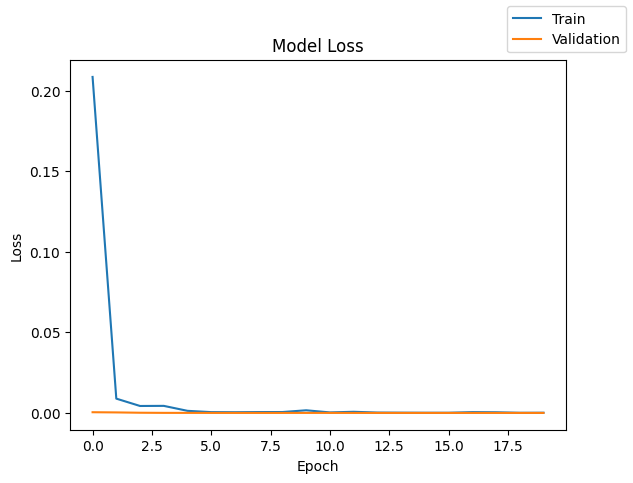

In [ ]:
#plot loss
plot(history, 'loss')

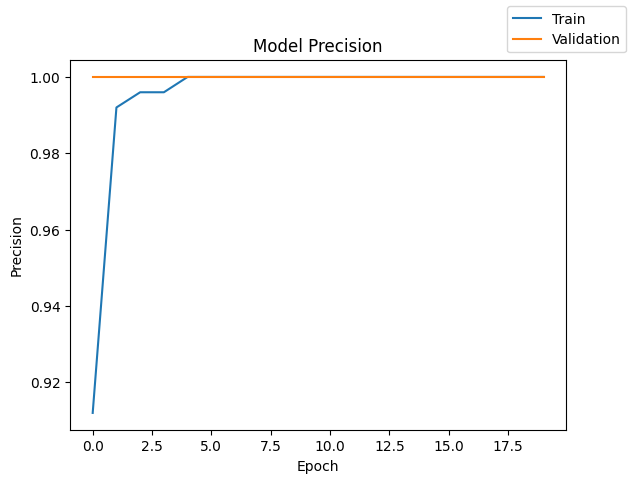

In [ ]:
#plot recall
plot(history, 'precision')

In [ ]:
#show eval metrics
model6_train_perf = model_performance_classification(model6, X_train_rgb_norm, y_train_rgb)
model6_train_perf.insert(0, "Name",  "VGG w/ANN Train RGB")

print("Train performance metrics")
print(model6_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
Train performance metrics
                  Name  Accuracy  Recall  Precision  F1 Score
0  VGG w/ANN Train RGB       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


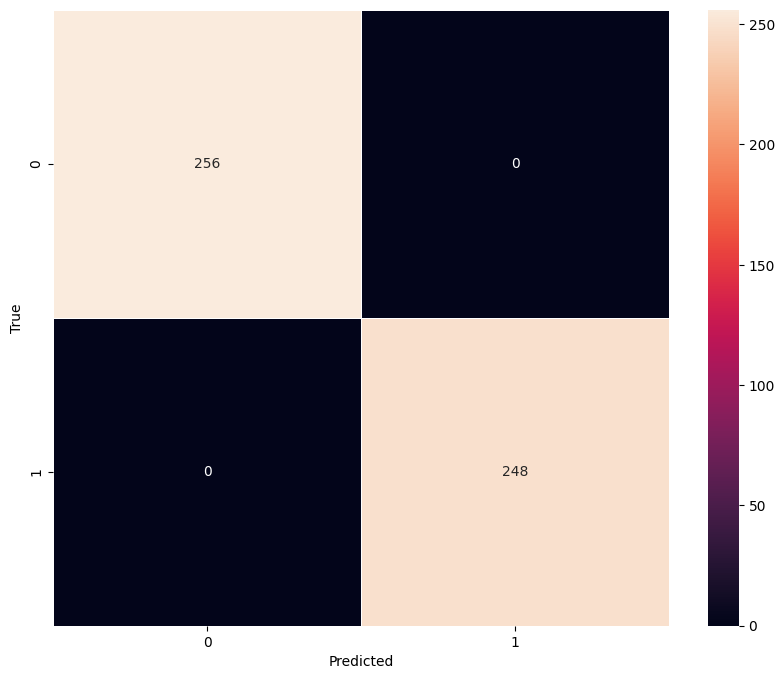

In [ ]:
#show confusion matrix
model6_train_cm = plot_confusion_matrix(model6, X_train_rgb_norm, y_train_rgb)

In [ ]:
#show eval metrics
model6_val_perf = model_performance_classification(model6, X_val_rgb_norm, y_val_rgb)
model6_val_perf.insert(0, "Name",  "VGG w/ANN Val RGB")
print("Validation performance metrics")
print(model6_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Validation performance metrics
                Name  Accuracy  Recall  Precision  F1 Score
0  VGG w/ANN Val RGB       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


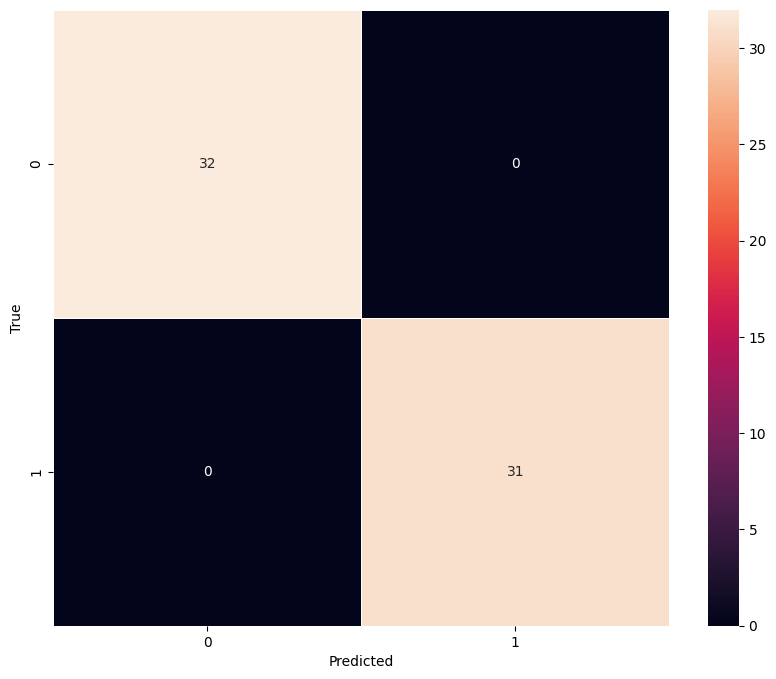

In [ ]:
#show confusion matrix
model6_val_cm = plot_confusion_matrix(model6, X_val_rgb_norm, y_val_rgb)

In [ ]:
results = pd.concat([results, model6_train_perf, model6_val_perf], axis = 0)
results

Name  Accuracy    Recall  Precision  F1 Score
0      Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077
0        Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236
0       Simple CNN Train RGB  0.990079  0.990079   0.990269  0.990077
0         Simple CNN Val RGB  0.968254  0.968254   0.970121  0.968206
0        VGG Base Train Gray  1.000000  1.000000   1.000000  1.000000
0          VGG Base Val Gray  1.000000  1.000000   1.000000  1.000000
0         VGG Base Train RGB  1.000000  1.000000   1.000000  1.000000
0           VGG Base Val RGB  1.000000  1.000000   1.000000  1.000000
0  VGG Base w/ANN Train Gray  1.000000  1.000000   1.000000  1.000000
0         VGG w/ANN Val Gray  1.000000  1.000000   1.000000  1.000000
0        VGG w/ANN Train RGB  1.000000  1.000000   1.000000  1.000000
0          VGG w/ANN Val RGB  1.000000  1.000000   1.000000  1.000000

Model 6 also achieved perfect scores and minimal loss, but appeared to take a little longer to figure things out on the training dataset than the previous models did. It also had a minimal increase in loss on the training dataset around the tenth epoch, but it's negligible.

#### Visualizing the prediction:

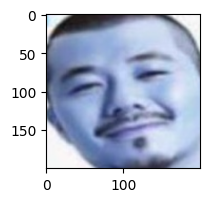

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted:  [[0]]
Truth: Label    0
Name: 603, dtype: int64


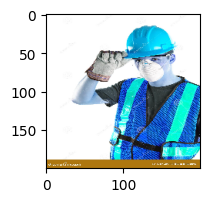

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 160, dtype: int64


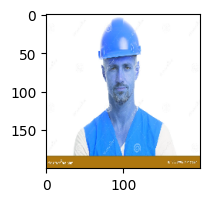

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 113, dtype: int64


In [ ]:
# Visualizing the predicted and correct labels of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[2])
plt.show()
imgpred1 = model6.predict(X_val_rgb_norm[2].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[14])
plt.show()
imgpred1 = model6.predict(X_val_rgb_norm[14].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[14])

plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[41])
plt.show()
imgpred1 = model6.predict(X_val_rgb_norm[41].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[41])

All three images are correct predictions.

## Model 7, 8: VGG-16 (Base + FFNN + Data Augmentation with Gray and RGB

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

###Gray Images

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
#initialize model7
model7 = Sequential()

#add vgg's convolutional layers
model7.add(vgg_model)

#flatten vgg's convolutional output
model7.add(Flatten())

#ann
model7.add(Dense(128, activation = 'relu'))
model7.add(Dropout(rate=0.4))
model7.add(Dense(64, activation = 'relu'))

#add output layer with 2 neurons and sigmoid for a binary classification problem
model7.add(Dense(1, activation='sigmoid'))

In [ ]:
#binary crossentropy for binary target variable
optimizer = "adam"
model7.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['precision'])
model7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,082,433 (65.16 MB)

 Trainable params: 2,367,745 (9.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#data augmentation
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    height_shift_range= 0.3,
    width_shift_range=0.3,
    rotation_range=20,
    shear_range = 0.2,
    zoom_range=0.3)

In [ ]:
#batch size
batch_size = 12

#applying data augmentation to normalized rgb images
train_generator = train_datagen.flow(X_train_gray_norm_vgg,
                                     y_train_gray,
                                     batch_size = batch_size,
                                     seed = 42, #to make this reproducible
)

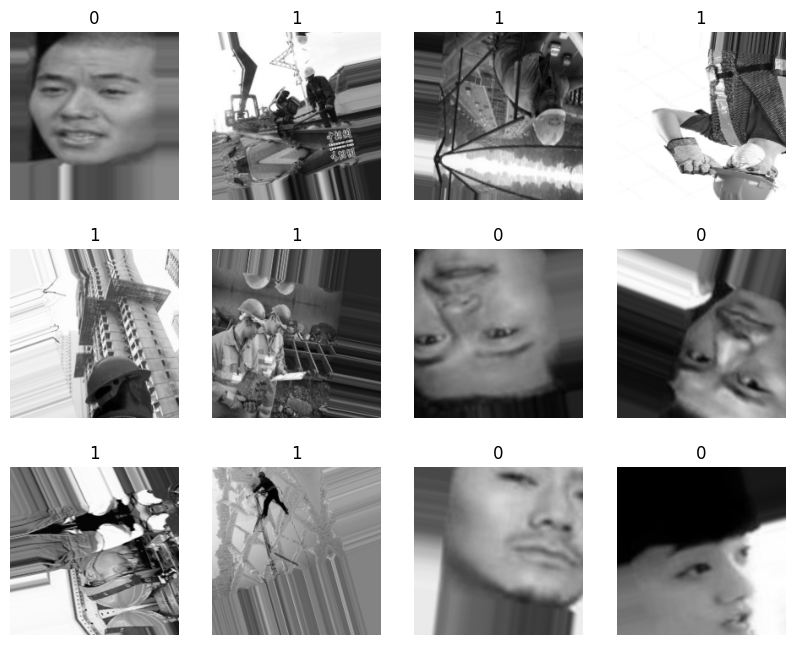

In [ ]:
#inspect augmented images -- from cnn transfer learning notebook, with tweaks
images_aug, labels_aug = next(train_generator)
fig, axes = plt.subplots(3, 4, figsize = (16, 8))
fig.set_size_inches(10, 8)
for (image, label, ax) in zip(images_aug, labels_aug, axes.flatten()):
    ax.imshow(image)
    if label == 1:
        ax.set_title('1')
    else:
        ax.set_title('0')
    ax.axis('off')

We can see that the images have been rotated, flipped, etc.

In [ ]:
#epochs
epochs = 20

#fit model
history = model7.fit(train_generator,
                     validation_data = (X_val_gray_norm_vgg, y_val_gray),
                     epochs = epochs,
                     batch_size = batch_size,
                     shuffle = True,
                     verbose = 2,
                     steps_per_epoch = X_train_gray_norm_vgg.shape[0] // batch_size, #added to specify that an epoch is complete once the model has seen 504 // 12, which is 42
                     )

Epoch 1/20
42/42 - 8s - 196ms/step - loss: 0.2020 - precision: 0.9008 - val_loss: 6.0224e-04 - val_precision: 1.0000
Epoch 2/20
42/42 - 6s - 147ms/step - loss: 0.0445 - precision: 0.9839 - val_loss: 0.0055 - val_precision: 1.0000
Epoch 3/20
42/42 - 6s - 145ms/step - loss: 0.0434 - precision: 0.9839 - val_loss: 2.3323e-04 - val_precision: 1.0000
Epoch 4/20
42/42 - 6s - 148ms/step - loss: 0.0096 - precision: 1.0000 - val_loss: 5.3566e-05 - val_precision: 1.0000
Epoch 5/20
42/42 - 6s - 145ms/step - loss: 0.0255 - precision: 0.9919 - val_loss: 3.0019e-05 - val_precision: 1.0000
Epoch 6/20
42/42 - 6s - 148ms/step - loss: 0.0203 - precision: 0.9920 - val_loss: 6.3685e-05 - val_precision: 1.0000
Epoch 7/20
42/42 - 6s - 146ms/step - loss: 0.0310 - precision: 0.9960 - val_loss: 9.6759e-04 - val_precision: 1.0000
Epoch 8/20
42/42 - 6s - 149ms/step - loss: 0.0091 - precision: 1.0000 - val_loss: 1.3508e-04 - val_precision: 1.0000
Epoch 9/20
42/42 - 6s - 147ms/step - loss: 0.0066 - precision: 1.000

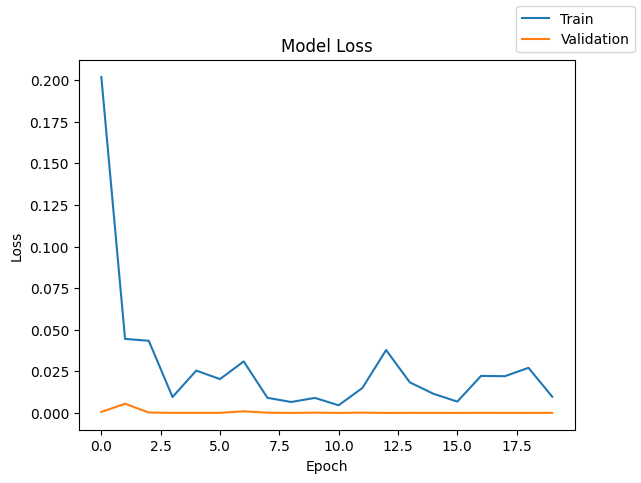

In [ ]:
#plot loss
plot(history, 'loss')

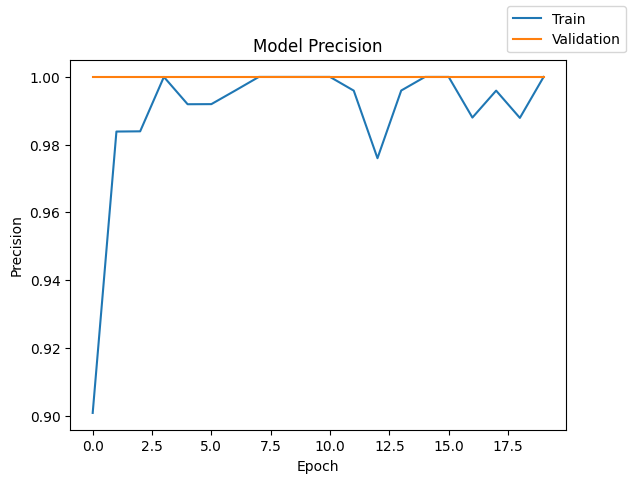

In [ ]:
#plot recall
plot(history, 'precision')

In [ ]:
#show eval metrics
model7_train_perf = model_performance_classification(model7, X_train_gray_norm_vgg, y_train_rgb)
model7_train_perf.insert(0, "Name",  "VGG w/ANN + data aug Train Gray")

print("Train performance metrics")
print(model7_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
Train performance metrics
                              Name  Accuracy    Recall  Precision  F1 Score
0  VGG w/ANN + data aug Train Gray  0.998016  0.998016   0.998024  0.998016


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


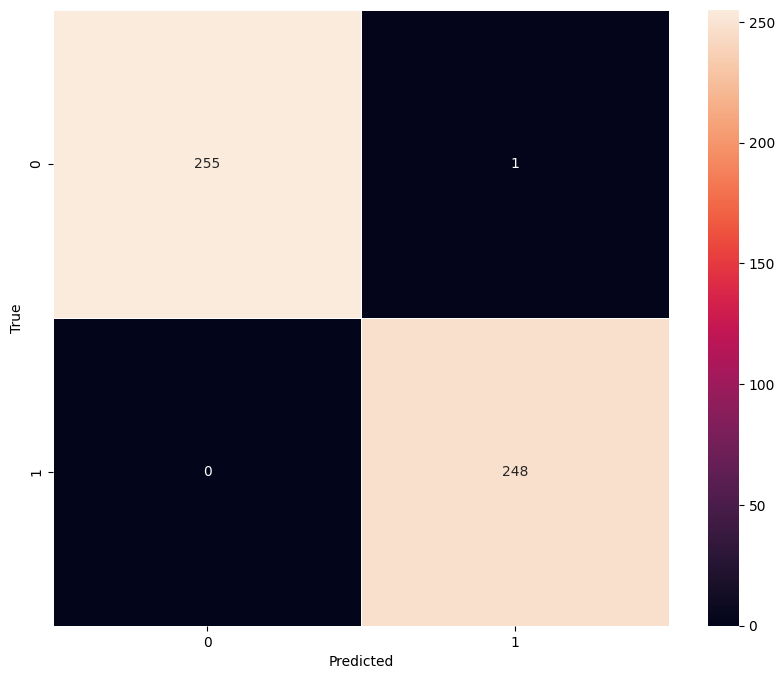

In [ ]:
#show confusion matrix
model7_train_cm = plot_confusion_matrix(model7, X_train_gray_norm_vgg, y_train_rgb)

In [ ]:
#show eval metrics
model7_val_perf = model_performance_classification(model7, X_val_gray_norm_vgg, y_val_rgb)
model7_val_perf.insert(0, "Name",  "VGG w/ANN + data aug Val Gray")
print("Validation performance metrics")
print(model7_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Validation performance metrics
                            Name  Accuracy  Recall  Precision  F1 Score
0  VGG w/ANN + data aug Val Gray       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


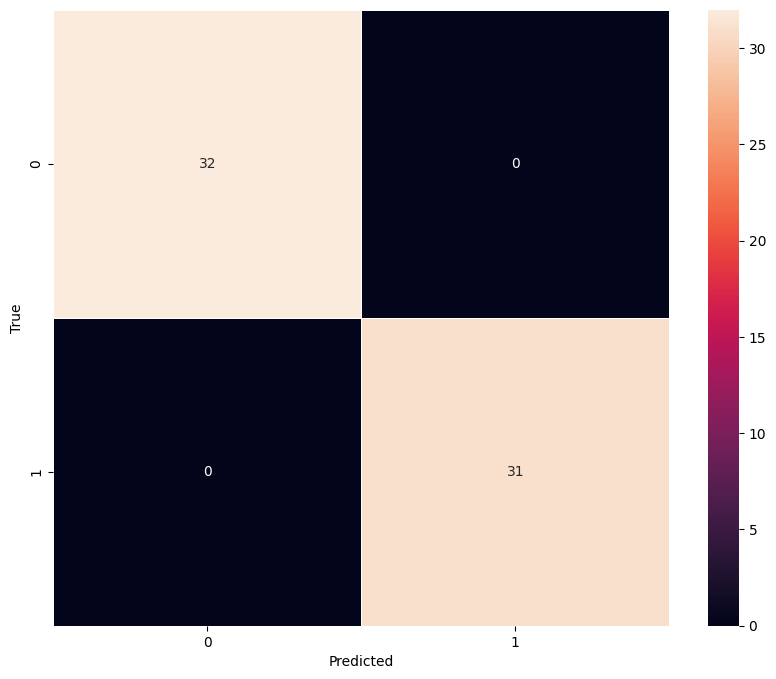

In [ ]:
#show confusion matrix
model7_val_cm = plot_confusion_matrix(model7, X_val_gray_norm_vgg, y_val_rgb)

In [ ]:
results = pd.concat([results, model7_train_perf, model7_val_perf], axis = 0)
results

Name  Accuracy    Recall  Precision  F1 Score
0            Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077
0              Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236
0             Simple CNN Train RGB  0.990079  0.990079   0.990269  0.990077
0               Simple CNN Val RGB  0.968254  0.968254   0.970121  0.968206
0              VGG Base Train Gray  1.000000  1.000000   1.000000  1.000000
0                VGG Base Val Gray  1.000000  1.000000   1.000000  1.000000
0               VGG Base Train RGB  1.000000  1.000000   1.000000  1.000000
0                 VGG Base Val RGB  1.000000  1.000000   1.000000  1.000000
0        VGG Base w/ANN Train Gray  1.000000  1.000000   1.000000  1.000000
0               VGG w/ANN Val Gray  1.000000  1.000000   1.000000  1.000000
0              VGG w/ANN Train RGB  1.000000  1.000000   1.000000  1.000000
0                VGG w/ANN Val RGB  1.000000  1.000000   1.000000  1.000000
0  VGG w/ANN + data aug Train Gray  0.998016  0.998016   0.998024  0.998016
0    VGG w/ANN + data aug Val Gray  1.000000  1.000000   1.000000  1.000000

Doing data augmentation was a new challenge for Model 7 -- it achieved less-than-perfect scores on the training dataset, though it did achieve the perfect scores again with the validation dataset. There was a minimal increase in validation loss around the first epoch. The performance on the training dataset was rather unstable though. The confusion matrix shows there was one false positive, which is the mistake we're trying to avoid.

#### Visualizing the prediction:

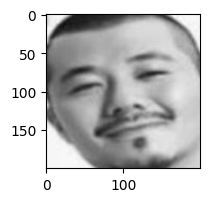

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted:  [[0]]
Truth: Label    0
Name: 603, dtype: int64


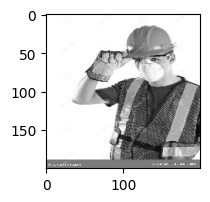

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 160, dtype: int64


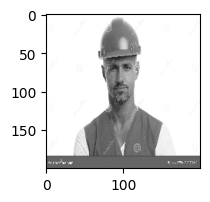

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 113, dtype: int64


In [ ]:
# Visualizing the predicted and correct labels of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm_vgg[2], cmap = 'gray')
plt.show()
imgpred1 = model7.predict(X_val_gray_norm_vgg[2].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val_gray_norm_vgg[14], cmap = 'gray')
plt.show()
imgpred1 = model7.predict(X_val_gray_norm_vgg[14].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[14])

plt.figure(figsize=(2,2))
plt.imshow(X_val_gray[41], cmap = 'gray')
plt.show()
imgpred1 = model7.predict(X_val_gray_norm_vgg[41].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[41])

All three predictions were correct again.

###RGB Images

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
#initialize model8
model8 = Sequential()

#add vgg's convolutional layers
model8.add(vgg_model)

#flatten vgg's convolutional output
model8.add(Flatten())

#ann
model8.add(Dense(128, activation = 'relu'))
model8.add(Dropout(rate=0.4))
model8.add(Dense(64, activation = 'relu'))

#add output layer with 2 neurons and sigmoid for a binary classification problem
model8.add(Dense(1, activation='sigmoid'))

In [ ]:
#binary crossentropy for binary target variable
optimizer = "adam"
model8.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['precision'])
model8.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,082,433 (65.16 MB)

 Trainable params: 2,367,745 (9.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#data augmentation
train_datagen2 = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    height_shift_range= 0.3,
    width_shift_range=0.3,
    rotation_range=20,
    shear_range = 0.2,
    zoom_range=0.3)

In [ ]:
#batch size
batch_size = 12

#applying data augmentation to normalized rgb images
train_generator = train_datagen2.flow(X_train_rgb_norm,
                                     y_train_rgb,
                                     batch_size = batch_size,
                                     seed = 42, #to make this reproducible
)

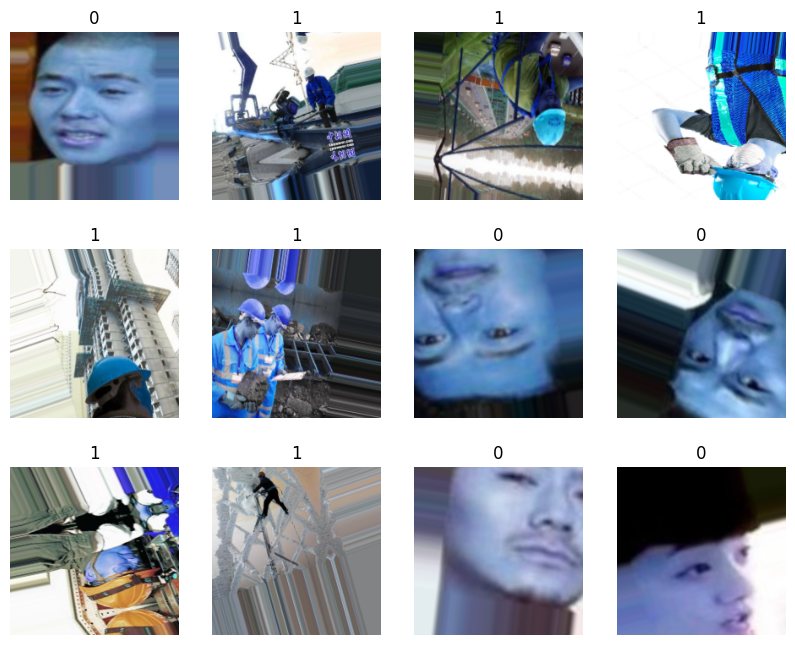

In [ ]:
#inspect augmented images -- from cnn transfer learning notebook, with tweaks
images_aug, labels_aug = next(train_generator)
fig, axes = plt.subplots(3, 4, figsize = (16, 8))
fig.set_size_inches(10, 8)
for (image, label, ax) in zip(images_aug, labels_aug, axes.flatten()):
    ax.imshow(image)
    if label == 1:
        ax.set_title('1')
    else:
        ax.set_title('0')
    ax.axis('off')

We can see that the images have been rotated, flipped, etc.

In [ ]:
#epochs
epochs = 20

#fit model
history = model8.fit(train_generator,
                     validation_data = (X_val_rgb_norm, y_val_rgb),
                     epochs = epochs,
                     batch_size = batch_size,
                     shuffle = True,
                     verbose = 2,
                     steps_per_epoch = X_train_rgb_norm.shape[0] // batch_size, #added to specify that an epoch is complete once the model has seen 504 // 12, which is 42
                     )

Epoch 1/20
42/42 - 8s - 194ms/step - loss: 0.1238 - precision: 0.9395 - val_loss: 0.0148 - val_precision: 1.0000
Epoch 2/20
42/42 - 6s - 147ms/step - loss: 0.0342 - precision: 0.9918 - val_loss: 2.2906e-05 - val_precision: 1.0000
Epoch 3/20
42/42 - 6s - 146ms/step - loss: 0.0344 - precision: 0.9880 - val_loss: 1.1413e-05 - val_precision: 1.0000
Epoch 4/20
42/42 - 6s - 147ms/step - loss: 0.0080 - precision: 1.0000 - val_loss: 3.8840e-06 - val_precision: 1.0000
Epoch 5/20
42/42 - 6s - 146ms/step - loss: 0.0266 - precision: 0.9959 - val_loss: 2.4062e-04 - val_precision: 1.0000
Epoch 6/20
42/42 - 6s - 147ms/step - loss: 0.0328 - precision: 0.9840 - val_loss: 1.6116e-06 - val_precision: 1.0000
Epoch 7/20
42/42 - 6s - 147ms/step - loss: 0.0397 - precision: 0.9800 - val_loss: 1.2746e-06 - val_precision: 1.0000
Epoch 8/20
42/42 - 6s - 147ms/step - loss: 0.0052 - precision: 1.0000 - val_loss: 2.0580e-06 - val_precision: 1.0000
Epoch 9/20
42/42 - 6s - 146ms/step - loss: 0.0112 - precision: 0.996

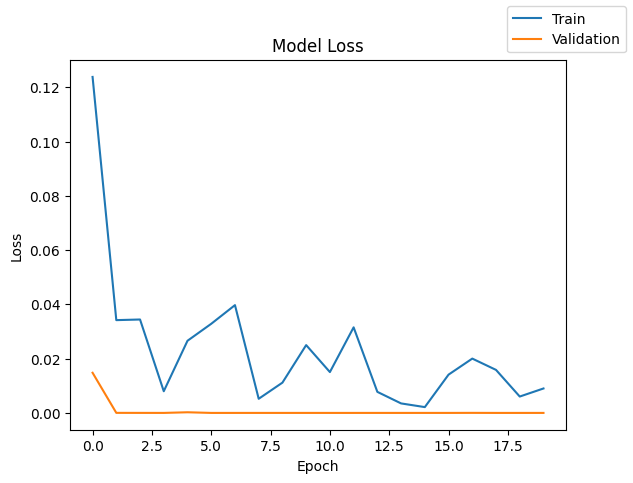

In [ ]:
#plot loss
plot(history, 'loss')

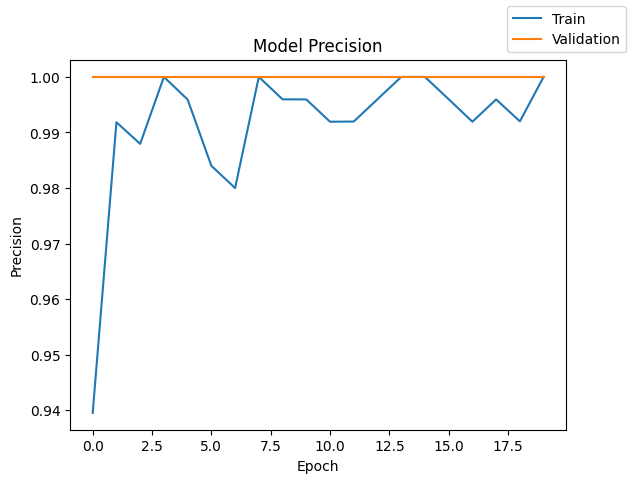

In [ ]:
#plot recall
plot(history, 'precision')

In [ ]:
#show eval metrics
model8_train_perf = model_performance_classification(model8, X_train_rgb_norm, y_train_rgb)
model8_train_perf.insert(0, "Name",  "VGG w/ANN + data aug Train RGB")

print("Train performance metrics")
print(model8_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
Train performance metrics
                             Name  Accuracy  Recall  Precision  F1 Score
0  VGG w/ANN + data aug Train RGB       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


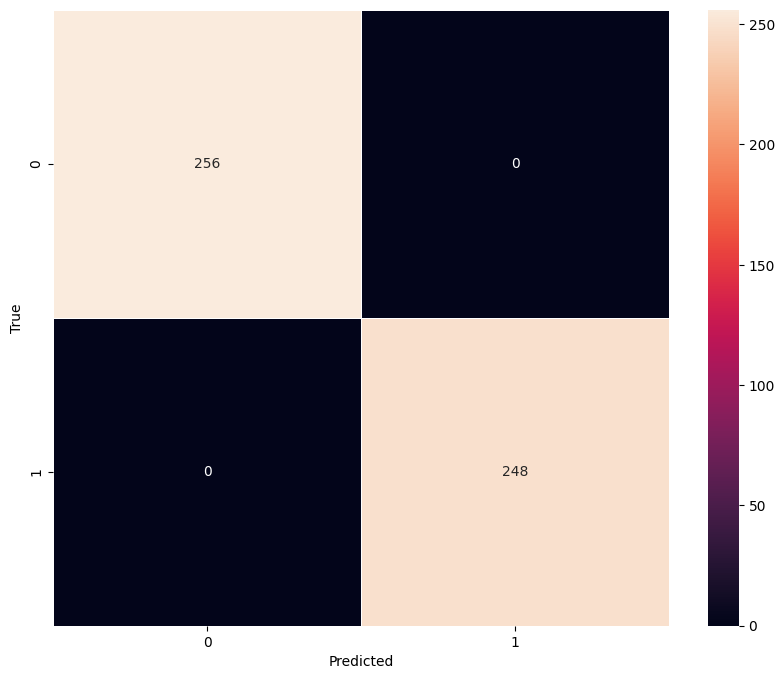

In [ ]:
#show confusion matrix
model8_train_cm = plot_confusion_matrix(model8, X_train_rgb_norm, y_train_rgb)

In [ ]:
#show eval metrics
model8_val_perf = model_performance_classification(model8, X_val_rgb_norm, y_val_rgb)
model8_val_perf.insert(0, "Name",  "VGG w/ANN + data aug Val RGB")
print("Validation performance metrics")
print(model8_val_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Validation performance metrics
                           Name  Accuracy  Recall  Precision  F1 Score
0  VGG w/ANN + data aug Val RGB       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


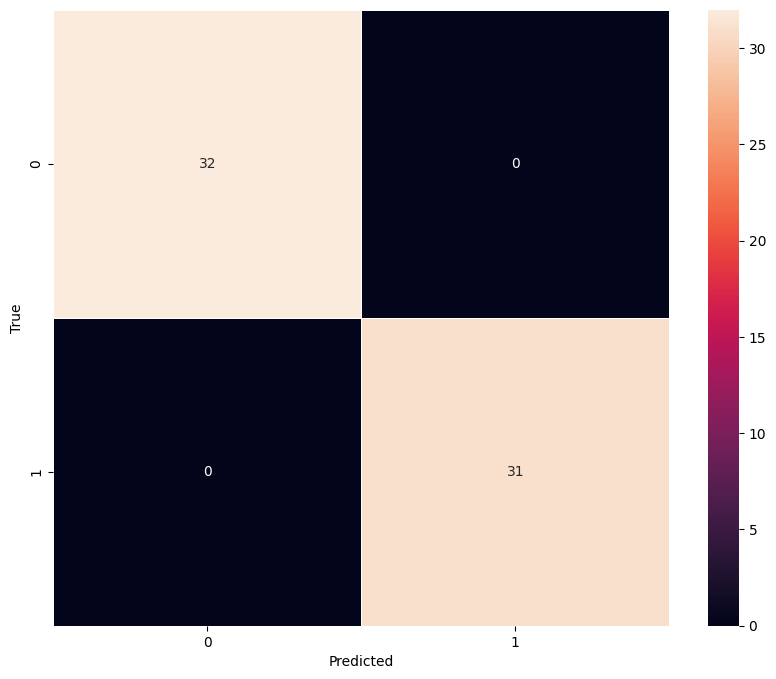

In [ ]:
#show confusion matrix
model8_val_cm = plot_confusion_matrix(model8, X_val_rgb_norm, y_val_rgb)

In [ ]:
results = pd.concat([results, model8_train_perf, model8_val_perf], axis = 0)
results

Name  Accuracy    Recall  Precision  F1 Score
0            Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077
0              Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236
0             Simple CNN Train RGB  0.990079  0.990079   0.990269  0.990077
0               Simple CNN Val RGB  0.968254  0.968254   0.970121  0.968206
0              VGG Base Train Gray  1.000000  1.000000   1.000000  1.000000
0                VGG Base Val Gray  1.000000  1.000000   1.000000  1.000000
0               VGG Base Train RGB  1.000000  1.000000   1.000000  1.000000
0                 VGG Base Val RGB  1.000000  1.000000   1.000000  1.000000
0        VGG Base w/ANN Train Gray  1.000000  1.000000   1.000000  1.000000
0               VGG w/ANN Val Gray  1.000000  1.000000   1.000000  1.000000
0              VGG w/ANN Train RGB  1.000000  1.000000   1.000000  1.000000
0                VGG w/ANN Val RGB  1.000000  1.000000   1.000000  1.000000
0  VGG w/ANN + data aug Train Gray  0.998016  0.998016   0.998024  0.998016
0    VGG w/ANN + data aug Val Gray  1.000000  1.000000   1.000000  1.000000
0   VGG w/ANN + data aug Train RGB  1.000000  1.000000   1.000000  1.000000
0     VGG w/ANN + data aug Val RGB  1.000000  1.000000   1.000000  1.000000

Model 8 had a similar performance to Model 7 -- it struggled a bit with the training dataset (though the loss was minimal), but it did achieve perfect precision before dropping a few times. On validation, it had a very small icnrease in loss before stabilizing around 0, and achieved perfect precision.

#### Visualizing the prediction:

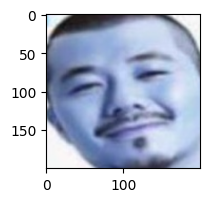

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted:  [[0]]
Truth: Label    0
Name: 603, dtype: int64


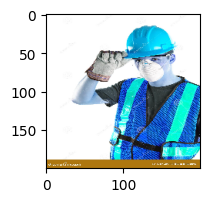

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 160, dtype: int64


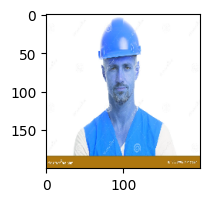

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted:  [[1]]
Truth: Label    1
Name: 113, dtype: int64


In [ ]:
# Visualizing the predicted and correct labels of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[2])
plt.show()
imgpred1 = model8.predict(X_val_rgb_norm[2].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[2])

plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[14])
plt.show()
imgpred1 = model8.predict(X_val_rgb_norm[14].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[14])

plt.figure(figsize=(2,2))
plt.imshow(X_val_rgb[41])
plt.show()
imgpred1 = model8.predict(X_val_rgb_norm[41].reshape(1,200,200,3))
imgpred1 = (imgpred1 > 0.5).astype(int)
print('Predicted: ', imgpred1)
print('Truth:', y_val_rgb.iloc[41])

All three images were correct predictions.

# **Model Performance Comparison and Final Model Selection**

In [ ]:
#see the metrics of all the models built
results

Name  Accuracy    Recall  Precision  F1 Score
0            Simple CNN Train Gray  0.990079  0.990079   0.990269  0.990077
0              Simple CNN Val Gray  0.952381  0.952381   0.956463  0.952236
0             Simple CNN Train RGB  0.990079  0.990079   0.990269  0.990077
0               Simple CNN Val RGB  0.968254  0.968254   0.970121  0.968206
0              VGG Base Train Gray  1.000000  1.000000   1.000000  1.000000
0                VGG Base Val Gray  1.000000  1.000000   1.000000  1.000000
0               VGG Base Train RGB  1.000000  1.000000   1.000000  1.000000
0                 VGG Base Val RGB  1.000000  1.000000   1.000000  1.000000
0        VGG Base w/ANN Train Gray  1.000000  1.000000   1.000000  1.000000
0               VGG w/ANN Val Gray  1.000000  1.000000   1.000000  1.000000
0              VGG w/ANN Train RGB  1.000000  1.000000   1.000000  1.000000
0                VGG w/ANN Val RGB  1.000000  1.000000   1.000000  1.000000
0  VGG w/ANN + data aug Train Gray  0.998016  0.998016   0.998024  0.998016
0    VGG w/ANN + data aug Val Gray  1.000000  1.000000   1.000000  1.000000
0   VGG w/ANN + data aug Train RGB  1.000000  1.000000   1.000000  1.000000
0     VGG w/ANN + data aug Val RGB  1.000000  1.000000   1.000000  1.000000

* The simple CNNs had very high performance scores, but the VGG-16 models had perfect scores almost across the board, with the exception of the VGG w/ANN trained on grayscale and data augmentation (model 7).
* The perfect scores are concerning, though -- as we saw during EDA, the big differences between the positive and negative classes (colors and headshots vs. wide shots) are likely easier for the models to identify than whether someone is pictured wearing a helmet.
* Data augmentation subjects the models to more robust training -- particularly since they include zooming, which may make the wider "positive" class shots appear more like tight shots in the "negative" class -- so the model can focus more on the presence of helmets
* Additionally, making the images grayscale makes all the images have the same color -- reducing the model's possible reliance on the blue-ish skin hue of the "negative" class to make classification decisions
* Model 7 was the only one of the VGG models to have less-than-perfect scores, and was the only one to have a false positive, which is what we're trying to avoid. However, these are all signs of a rigorous training process, which none of the other models showed -- instead, they all showed "perfect" scores, likely reliant on the color and headshot vs. wideshot classification "shortcuts". Thus, Model 7 may be more trustworthy than the others to truly classify images based on workers wearing helmets vs. workers without.
* It should also be noted that Model 7's mistakes and less-than-perfect scores only happened on the training set -- like the others, it scored "perfectly" on the validation set.
* Taking all this into account, we'll choose Model 7 -- VGG-16 w/ANN trained with grayscale images and with data augmentation -- as our final model.

## Test Performance

In [ ]:
#run model 7 on the test set -- Gray
#show eval metrics
model7_test_perf_gray = model_performance_classification(model7, X_test_gray_norm_vgg, y_test_rgb)
model7_test_perf_gray.insert(0, "Dataset",  "Gray")

print("Test performance metrics")
print(model7_test_perf_gray)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Test performance metrics
  Dataset  Accuracy  Recall  Precision  F1 Score
0    Gray       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


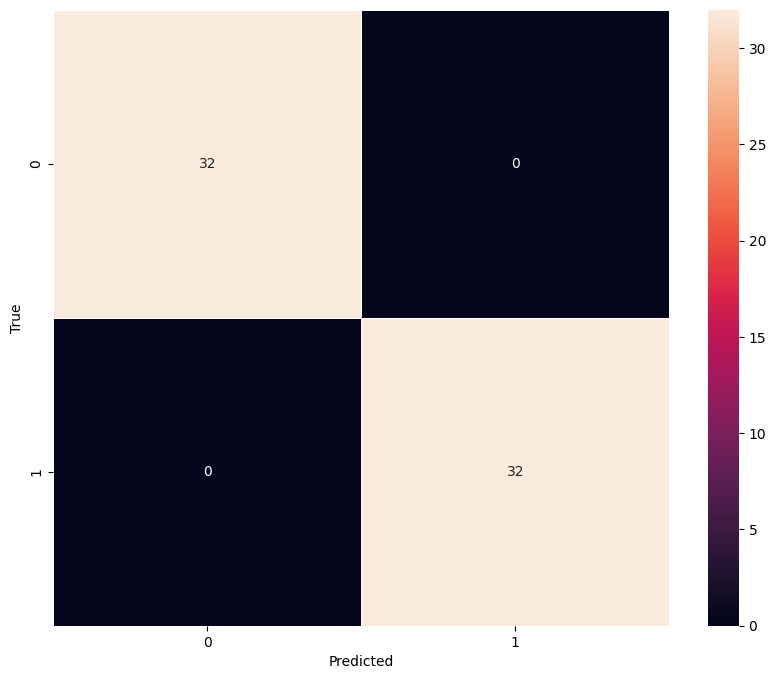

In [ ]:
#show confusion matrix
model7_test_cm_gray = plot_confusion_matrix(model7, X_test_gray_norm_vgg, y_test_rgb)

In [ ]:
precision = model7.evaluate(X_test_gray_norm_vgg, y_test_rgb, verbose=2)

2/2 - 0s - 186ms/step - loss: 4.9809e-06 - precision: 1.0000


In [ ]:
#run model 7 on the test set -- RGB
#show eval metrics
model7_test_perf_rgb = model_performance_classification(model7, X_test_rgb_norm, y_test_rgb)
model7_test_perf_rgb.insert(0, "Dataset",  "RGB")

print("Test performance metrics")
print(model7_test_perf_rgb)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Test performance metrics
  Dataset  Accuracy  Recall  Precision  F1 Score
0     RGB       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


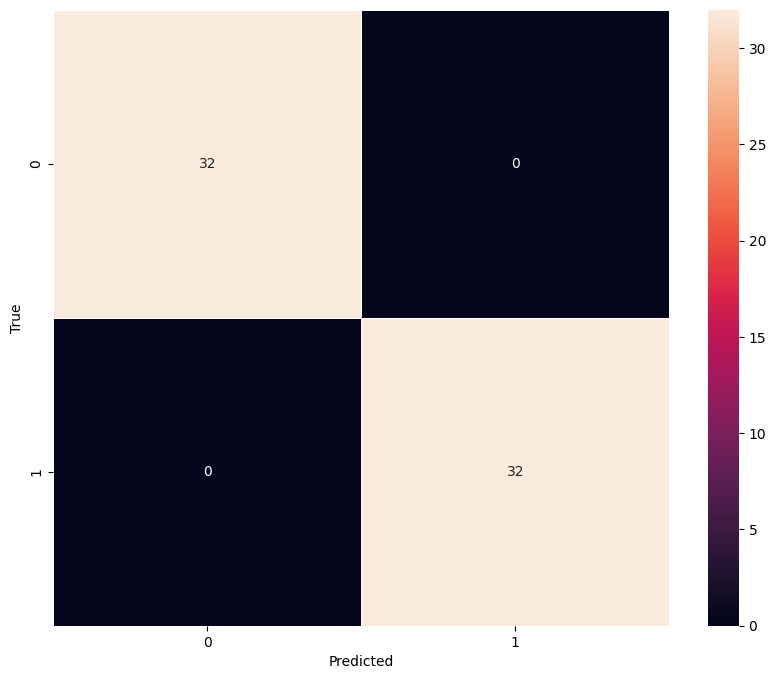

In [ ]:
#show confusion matrix
model7_test_cm = plot_confusion_matrix(model7, X_test_rgb_norm, y_test_rgb)

In [ ]:
precision = model7.evaluate(X_test_rgb_norm, y_test_rgb, verbose=2)

2/2 - 0s - 146ms/step - loss: 1.0146e-05 - precision: 1.0000


Model 7 achieved perfect scores on the RGB and gray test datasets.

# **Actionable Insights & Recommendations**

* The dataset posed a big challenge -- while our goal was to differentiate between images with people wearing helmets and people without helmets, the two classes were too different for other reasons -- the images of people without helmets were usually headshots and had a distinct color because of skintone, while images of people with helmets were usually wider shots and had more color variety. This meant the models learned to differentiate based on colors and headshot vs. wide shot, rather than whether someone was wearing a helmet.
* SafeGuard should seek a better-quality dataset with more uniform images of people with and without helmets -- both headshots and wide shots -- so the models can't rely on those features to differentiate.
* SafeGuard should also seek a bigger dataset -- 631 images didn't provide a lot of room for robust training and validation/test datasets.
* Despite the dataset limitations, VGG-16 w/ANN trained on grayscale images with data augmentation had the most promising performance because it was not able to rely on skintone colors for classification. Data augmentation also reduced its ability to rely on whether the image was a headshot or a wide shot.
* While this model struggled the most out of all the VGG-16 models during training, that struggle showed it was going through a robust learning process -- while all the other VGG-16 models simply appeared to learn the skintone and headshot-vs-wide shot "shortcuts". Ultimately, that struggle during training did not result in comparably-worse performance on validation or test -- it still performed "perfectly" on those datasets.
* In addition to a better dataset, this model could also be enhanced by doing more aggressive data augmentation -- especially zoom, to further reduce the reliance on the close-up nature of headshots.

<font size=5 color='blue'>Power Ahead!</font>
___